# Gravitational N-body Simulation
William Fung

- Should run in O(mlog(m)), where m is the number of cells in particle mesh
- Comes at the cost of accuracy the lower the m

## 0. Libraries

In [34]:
# Python
from datetime import datetime
from time import time

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy

# NumPy
import numpy        as np
import numpy.random as random

## 1. Initial Conditions
- Set up particle grid with random pos, vel and, acc
- Random positions are such that they form a sphere of uniform density 
- Create graphs showing cross sections and distribution of mass to radius

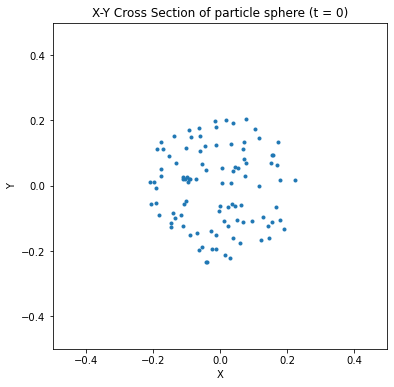

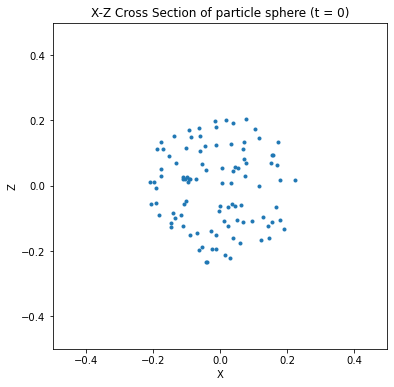

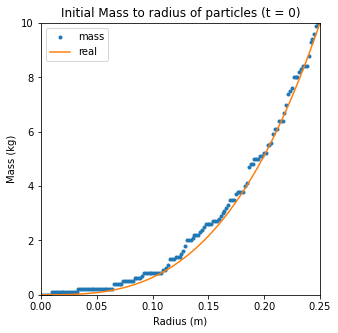

In [35]:
random.seed(1)
G = 6.67e-11 #m^3kg^-1s^-2

#Length of Grid (m)
L = 1

#Number of cells
Nc = 150
#Length of one cell
dr = L/Nc

#Number of particles
Np = 100#32**3

#Mass of particle (kg)
m = .1

#Sphere 
Ms = m*Np #kg
Rs = L/4  #m

def particles(Np, Nc, L, m, Rs):
    #Initialize pos, vel, acc of Particles in x, y, z
    part = np.zeros((9, Np))
    
    #Initialze Mass Distribution in R
    resultR = np.zeros(Nc)
    
    #Np Random numbers between 1-0 for r, theta, phi
    randnums = np.random.rand(3, Np)
    
    # 0 < r < Rs
    ###Transformation Method on Jacobian of Spherical
    # p(u)du = p(r)dr
    # (1) du = r^2 dr
    # u = (1/3)r^3
    # r = (3u)^(1/3)
    # random.rand() goes from 0 to 1; want 0 to Rs^3/3 --> u*Rs^3/3
    u_r = randnums[0]*Rs**3/3
    R = (3*u_r)**(1/3)

    # 0 < theta < pi
    # p(u)du = p(theta)dtheta
    # (1) du = sin(theta) dtheta
    # u = -cos(theta)
    # theta = arccos(-u)
    # random.rand() goes from 0 to 1; want -1 to 1 --> u*2 - 1
    u_theta = 2*randnums[1] - 1
    Theta = np.arccos(u_theta)

    # 0 < phi < 2pi
    # p(u)du = p(phi)phi
    # (1) du = (1) dphi
    # u = phi
    # random.rand() goes from 0 to 1; want 0 to 2pi --> u*2*pi
    u_phi = randnums[2]*2*np.pi
    Phi = u_phi

    #Spherical Coordinates
    part[0] = R*np.sin(Theta)*np.cos(Phi)
    part[1] = R*np.sin(Theta)*np.sin(Phi)
    part[2] = R*np.cos(Theta)

    #keep filling up masses for each random r produced
    R = (np.round(R/Rs*Nc)).astype(int) - 1
    np.add.at(resultR, R, m)
    
    #Mass from center to r
    resultR = np.add.accumulate(resultR)

    return part, resultR

part, resultR = particles(Np, Nc, L, m, Rs)
part_x = part[0]
part_y = part[1]
part_z = part[2]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(part_x, part_z, '.')
ax.axis([-L/2, L/2, -L/2, L/2])
ax.set_title('X-Y Cross Section of particle sphere (t = 0)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111)
ax1.plot(part_x, part_z, '.')
ax1.axis([-L/2, L/2, -L/2, L/2])
ax1.set_title('X-Z Cross Section of particle sphere (t = 0)')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')

#plot M(<r) to r to check if have a curve of r^3
# M(<r)/Ms = (r/Rs)**3
x = np.linspace(0, Rs, Nc)
f = Ms*(x/Rs)**3

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)
ax2.plot(x, resultR, '.', label = 'mass')
ax2.plot(x, f, label = 'real')
ax2.axis([0, Rs, 0, Ms])
ax2.set_title('Initial Mass to radius of particles (t = 0)')
ax2.set_xlabel('Radius (m)')
ax2.set_ylabel('Mass (kg)')
ax2.legend()

plt.show()

# 2. Cloud in Cell for Density
- Density function $\rho(x)$ takes in the particle information and 
    outputs the density distribution of the mass
    - In the cloud-in-cell (CIC) scheme, each particle is assumed to have the
        same shape as a grid cell and can overlap with up to 8 nearby cells in 3D
    - The fraction of the particle mass assigned to a neighbor cell 
        is equal to the fraction of the particle volume overlap

In [36]:
#Volume of a cell (m**3)
Vc = dr**3

#Radius of a cell (m)
rc = dr/2

#Determines for each mass how much mass goes into neighboring cells
#Returns volume sections and cell indicies for each particle
def volume_sections(part):
    xp = (part[0] + L/2)%L
    yp = (part[1] + L/2)%L
    zp = (part[2] + L/2)%L

    xiter = (np.round(xp*Nc)).astype(int)
    yiter = (np.round(yp*Nc)).astype(int)
    ziter = (np.round(zp*Nc)).astype(int)
    
    ### Catch particles at boundaries for future indexing
    #idk if this is correct
    if np.any(xiter == Nc):
        ix = np.where(xiter == Nc)
        xiter[ix] = 0
        xp[ix] = 0
    if np.any(yiter == Nc):
        iy = np.where(yiter == Nc)
        yiter[iy] = 0
        yp[iy] = 0
    if np.any(ziter == Nc):
        iz = np.where(ziter == Nc)
        ziter[iz] = 0
        zp[iz] = 0
    ###
    
    xi = xiter/Nc
    yi = yiter/Nc
    zi = ziter/Nc

    x0 = xp - rc
    x1 = xp + rc
    y0 = yp - rc
    y1 = yp + rc
    z0 = zp - rc
    z1 = zp + rc

    Lx0, Ly0, Lz0 = abs(x0 - xi), abs(y0 - yi), abs(z0 - zi)
    Lx1, Ly1, Lz1 = abs(x1 - xi), abs(y1 - yi), abs(z1 - zi)

    V = np.array([Lx1*Lz0*Ly0, Lx0*Lz0*Ly0, Lx0*Lz1*Ly0, Lz1*Lx1*Ly0, 
                  Lx1*Lz0*Ly1, Lx0*Lz0*Ly1, Lx0*Lz1*Ly1, Lz1*Lx1*Ly1])
    
    return V, xiter, yiter, ziter

#Create Density mesh
def density(part):
    result = np.zeros((Nc, Nc, Nc))
    V, xiter, yiter, ziter = volume_sections(part)
    
    I = []
    I.append(tuple(np.array([xiter, yiter - 1, ziter - 1])))
    I.append(tuple(np.array([xiter - 1, yiter - 1, ziter - 1])))
    I.append(tuple(np.array([xiter - 1, yiter, ziter - 1])))
    I.append(tuple(np.array([xiter, yiter, ziter - 1])))
    I.append(tuple(np.array([xiter, yiter - 1, ziter])))
    I.append(tuple(np.array([xiter - 1, yiter - 1, ziter])))
    I.append(tuple(np.array([xiter - 1, yiter, ziter])))
    I.append(tuple(np.array([xiter, yiter, ziter])))
    
    # result[i[0], i[1], i[2]] += v/Vc*m with buffering
    for i, v in zip(I, V):
        np.add.at(result, i, v/Vc*m)
        
    return result/Vc

#rho = mass/vol
begin = time()
rhox = density(part)
#onepart = [[.05], [-.04], [.06]]
end = time()
print("elapsed time: ", end - begin, "sec.")

elapsed time:  0.08797812461853027 sec.


# 3. Poisson's Equation
$\nabla^2 \Phi(x) = 4\pi G\rho(x)$

The general solution is a convlution:\
$\Phi(x) = \int(\rho(x')w(|x - x'|))dx'$

Isotropic Kernel is given from Poisson Equation by:\
$w(k) = -\frac{4\pi G}{k^2}$\
"Poor Man's solver" (Boris and Roberts, 1969)

And:\
$k^2 = 2sin(\frac{k_x}{2})^2 + 2sin(\frac{k_y}{2})^2 + 2sin(\frac{k_z}{2})^2$\

$\begin{equation}
k =
    \begin{cases}
        \frac{2\pi}{N_k}k & \text{if } k = 1, 2, ..., N_k/2\\
        \frac{2\pi}{N_k}(k - N_k) & \text{if } k = N_k/2 + 1, N_k + 1
    \end{cases}
\end{equation}$\
$k \in N_k$

$\rightarrow \Phi(k) = \rho(k)*w(k)$


In [37]:
#FFT of rho(x) to get rho(k)
rhok = np.fft.rfftn(rhox) 
Ni, Nj, Nk = rhok.shape
#>>>128, 128, 65 <--- positive wave vectors

###Wavenumber function
#Input for kx, ky, kz
def wavenum(N): 
    mid = N//2 + 1
    result = np.zeros(N)
    for k in range(N):
        if k < mid:
            result[k] += 2*np.pi*k/Nc
        else:
            result[k] += 2*np.pi*(k - N)/Nc
    return result

#Produces wavenumber array for three dimensions
def wavexyz(Ni, Nj, Nk):
    wavex = wavenum(Ni)
    wavey = wavenum(Nj)
    wavez = wavenum(Nk)
    return np.array([wavex, wavey, wavez])

### Gravitational Kernel (w(k)):
def grav_kernel(wave):
    def sin_wave(k):
        return 2*np.sin(k/2)
    X, Y, Z = sin_wave(wave[0]), sin_wave(wave[1]), sin_wave(wave[2])
    
    #Get every permutation of X, Y, Z
    XX, YY, ZZ = np.meshgrid(X, Y, Z)
    RR2 = (XX**2 + YY**2 + ZZ**2)
    
    #Exclude 0,0,0 to avoid division error
    result = np.divide(-4*G*np.pi, RR2, out = np.zeros_like(RR2), where=(RR2!=0))
    
    return result

wave = wavexyz(Ni, Nj, Nk)
begin = time()
wk = grav_kernel(wave)
end = time()
print("elapsed time wk: ", end - begin, "sec.")

phik = rhok * wk

###Gravitational Potential
phix = np.fft.irfftn(phik)
Npi, Npj, Npk = phix.shape
#>>>128, 128, 128

print("Done")


elapsed time wk:  0.0696711540222168 sec.
Done


## 4. Cloud in Cell for Gravitational Force
$\vec{f} = -\nabla \Phi(x)$

Then finite difference $\vec{f}$ to recieve force per unit mass for each particle

In [38]:
#vector f = -grad(phix)
fvector = -np.array(np.gradient(phix, dr))

#Cartesian mesh grid for force per unit mass
def Force_per_mass(part, fvector):
    result = np.zeros((3, Np))
    for n in range(3): #0:x; 1:y; 2:Z
        fndir = fvector[n]
        V, xiter, yiter, ziter = volume_sections(part)
    
        F = [fndir[xiter, yiter - 1, ziter - 1]]
        F.append(fndir[xiter - 1, yiter - 1, ziter - 1])
        F.append(fndir[xiter - 1, yiter, ziter - 1])
        F.append(fndir[xiter, yiter, ziter - 1])
        F.append(fndir[xiter, yiter - 1, ziter])
        F.append(fndir[xiter - 1, yiter - 1, ziter])
        F.append(fndir[xiter - 1, yiter, ziter])
        F.append(fndir[xiter, yiter, ziter])
        F = np.asarray(F)
        
        for v, f in zip(V, F): #range 8
            result[n] += v/Vc*f
        
    return result/Ms

#Calculate initial f/m (unit force of one mass, or acceleration)
#off by factors of dr due to normalization of FFT and IFFTs
begin = time()
f0 = Force_per_mass(part, fvector)*dr**2
end = time()
print("elapsed time force: ", end - begin, "sec.")
#print(fvector)

elapsed time force:  0.000885009765625 sec.


## 5. Cold Gravitational Collapse
- Calculate initial acceleration from initial $\vec{f}$ and initial dt
- Create functions to calculate Mass and acceleration as functions of radius

In [39]:
###Calculate initial dt from acceleration
lam = .5
delta = dr
mag_f0 = np.sqrt((f0[0])**2 + (f0[1])**2 + (f0[2])**2)
amax = max(mag_f0)
dt0 = lam*np.sqrt(delta/amax) #accelerations acting on every particle
print("amax =", amax)
print("initial dt =",  dt0)

#Function to find M(r)
def mEnclosed(part, Rs, Nc):
    result = np.zeros(Nc)
    R = np.sqrt((part[0])**2 + (part[1])**2 + part[2]**2)
    
    #Mass from center to r
    result = np.add.accumulate(result)
    
    for r in R:
        i = int(round(r/Rs*Nc - 1))
        if i < Nc:
            result[i] += m
    result = np.add.accumulate(result)
    
    return result

#Function to find A(r)
def accEnclosed(part, Rs, Nc):
    result = np.zeros(Nc)
    R = np.sqrt((part[0])**2 + (part[1])**2 + part[2]**2)
    A = np.sqrt((part[6])**2 + (part[7])**2 + part[8]**2)
    for r, a in zip(R, A):
        i = int(round(r/Rs*Nc - 1))
        if i < Nc:
            result[i] += a
            
    resAconst = copy.deepcopy(result)
    for n in range(Nc):
        result[n] += sum(resAconst[:n])/(n + 1)
    
    return result

amax = 7.555802296582301e-09
initial dt = 469.6605495475303


### Verlet Method
- Update position of particles based on force, update force based on position of particles
- Run N times
- Create graphs for every n_mult

In [42]:
def verlet(part0, wk, f0, dt, N_step, mult, lam):
    part = copy.deepcopy(part0)
    fx = copy.deepcopy(f0)
    n = 0
    
    #Dynamical time: Approximate time it takes to reach gravitational collapse
    rhoavg = Ms/(4/3*np.pi*Rs**3)
    tdyn = np.sqrt(3*np.pi/(16*G*rhoavg))
    print("dynamical time = ", tdyn)
    
    #Initial Acceleration a = f/m
    part[6] = fx[0]
    part[7] = fx[1]
    part[8] = fx[2]
    
    while n < N_step:
        ### Update position: x(n + 1) = x(n) + v(n)*Δt + 1/2*a(n)*(Δt)^2
        part[0] += part[3]*dt + part[6]*dt**2/2
        part[1] += part[4]*dt + part[7]*dt**2/2
        part[2] += part[5]*dt + part[8]*dt**2/2
        
        ### Update velocity: v(n + 1) = v(n) + v(n)*Δt + 1/2*a(n)*(Δt)^2
        ## 1. Add old acceleration: v(n + 1) += 1/2*a(n)*Δt
        part[3] += part[6]*dt/2
        part[4] += part[7]*dt/2
        part[5] += part[8]*dt/2
        
        ## 2. Update Force
        rhox = density(part)#, Np, Vc, rc, Nc, m)
        rhok = np.fft.rfftn(rhox) 
        phik = rhok * wk
        phix = np.fft.irfftn(phik)
        fvector = -np.array(np.gradient(phix))*np.sqrt(dr)#**2
        fx = Force_per_mass(part, fvector)
        # Update Acceleration a = f/m
        part[6] = fx[0]
        part[7] = fx[1]
        part[8] = fx[2]
        
        ## 3. Add new acceleration: v(n + 1) += 1/2*a(n + 1)*Δt
        part[3] += part[6]*dt/2
        part[4] += part[7]*dt/2
        part[5] += part[8]*dt/2
        
        #Update dt
        resultv = np.zeros(Np)
        resulta = np.zeros(Np)
        resultv = np.sqrt((part[3])**2 + (part[4])**2 + (part[5])**2)
        resulta = np.sqrt((part[6])**2 + (part[7])**2 + (part[8])**2)
        vmax = max(resultv)
        amax = max(resulta)
        delta = dr
        dt = lam*min(delta/vmax, np.sqrt(delta/amax))
        
        n += 1
        print(n, "dt = ", round(dt))
        
        if n % mult == 0:
            line = "------------------------------------------------"
            print(" %s n = %d %s "%(line, n, line))

            fig = plt.figure(figsize=(12,6))
            plt.subplot(121)
            plt.plot(part[0], part[1], '.')
            plt.axis([-L/2, L/2, -L/2, L/2])
            plt.xlabel('X (m)')
            plt.ylabel('Y (m)')
            plt.title("XY @ n = %d" %n)

            plt.subplot(122)
            plt.axis([-L/2, L/2, -L/2, L/2])
            plt.plot(part[0], part[2], '.')
            plt.title("XZ @ n = %d" %n)
            plt.xlabel('X (m)')
            plt.ylabel('Z (m)')
            plt.show()

            fig = plt.figure(figsize=(18,6))
            x = np.linspace(0, Rs, Nc)
            mEnc = mEnclosed(part, Rs, Nc)
            M_r = Ms*(x/Rs)**3
            
            plt.subplot(131)
            plt.plot(x, mEnc, '.', label = "mass enclosed")
            plt.plot(x, M_r, label = "real")
            plt.axis([0, Rs, 0, Ms])
            plt.title("M(r) @ n = %d" %n)
            plt.xlabel('r (m)')
            plt.ylabel('M(<r) (kg)')
            plt.legend()
            
            plt.subplot(132)
            accEnc = accEnclosed(part, Rs, Nc)
            plt.plot(x, accEnc, '.', label = "acceleration enclosed")
            aAvg = G*mEnc/(x + dr)**2
            plt.plot(x, aAvg, label = "real")
            plt.title("A(r) @ n = %d" %n)
            plt.xlabel('r (m)')
            plt.ylabel('a(<r) (m/s^2)')
            plt.legend()
            
            plt.subplot(133)
            Acc = np.column_stack((part[0], part[6]))
            accx, accax = Acc[Acc[:, 0].argsort()].T
            plt.plot(np.linspace(0, Np, Np), accx, '.', label = "x")
            plt.plot(np.linspace(0, Np, Np), accax*10**8, '.', label = "ax")
            plt.xlabel('particle')
            plt.title('Acceleration vs distance')
            plt.legend()
            
            plt.show()
    
    return 

### Run Simulation:
part: initial positions, velocities, and accelerations of particles (np.ndarray, 9xN)\
wk: Gravitational kernel (np.ndarray, 128x128x65)\
f0: initial force per unit mass (np.ndarry, 3xN)\
dt0: initial delta t (np.float64)\
N_step: number of steps to run for\
mult: multiple of N_step; will print graphs at every (mult) step\
lam: dimensionless quantity that determines how "fast" the simulation runs; $0 \leq \lambda \leq 1$

tdyn =  7602.684583829081
1 270.33 288.0 270.0
2 197.39 197.0 266.0
3 190.64 191.0 362.0
4 179.19 179.0 239.0
5 141.48 141.0 244.0
 ------------------------------------------------ n = 5 ------------------------------------------------ 


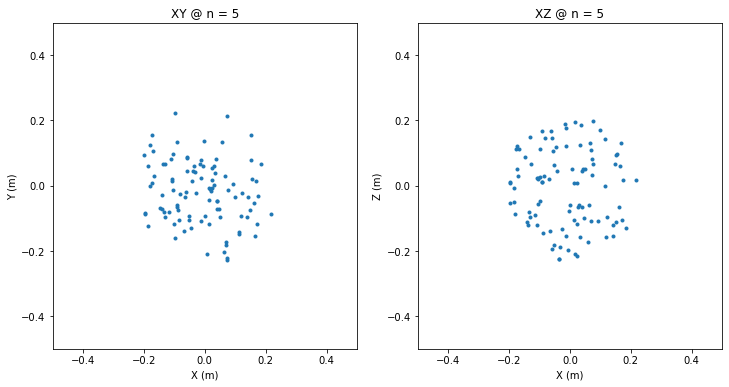

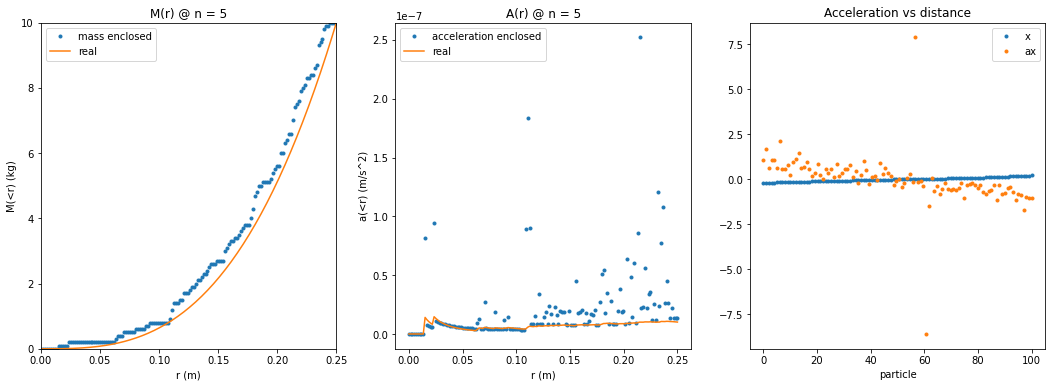

6 133.25 133.0 247.0
7 140.4 140.0 249.0
8 145.04 145.0 231.0
9 146.89 147.0 243.0
10 146.03 146.0 225.0
 ------------------------------------------------ n = 10 ------------------------------------------------ 


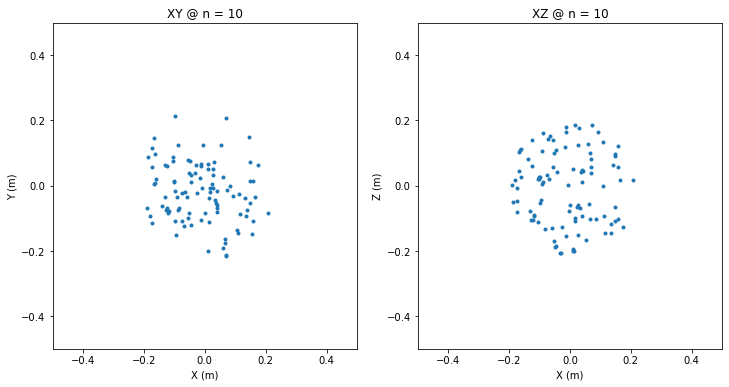

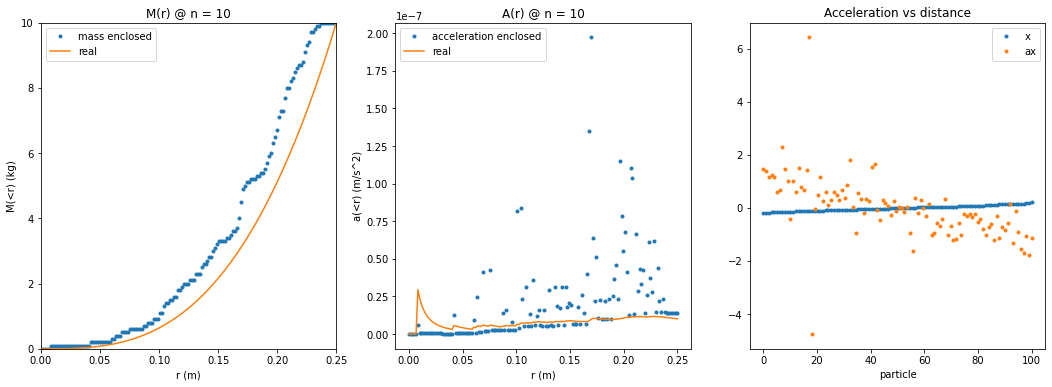

11 122.23 122.0 229.0
12 108.23 108.0 190.0
13 111.28 111.0 212.0
14 122.82 123.0 245.0
15 122.56 123.0 239.0
 ------------------------------------------------ n = 15 ------------------------------------------------ 


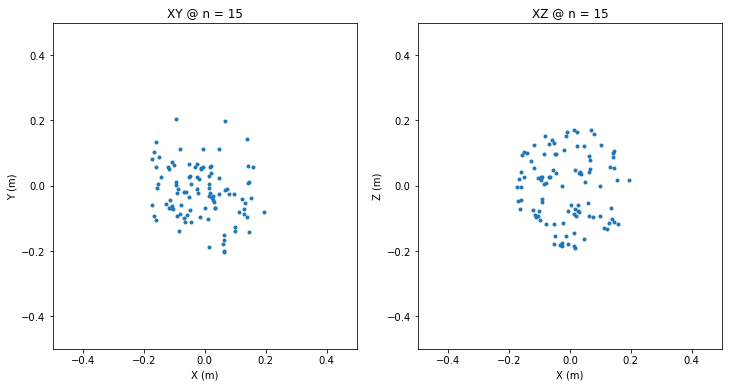

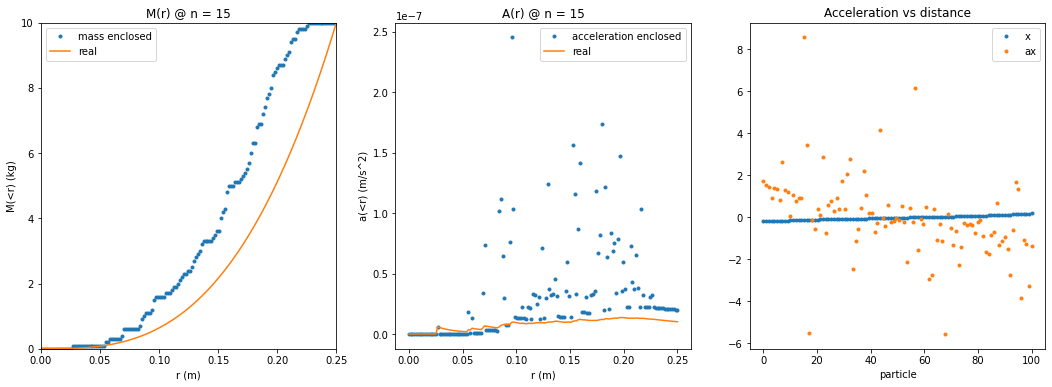

16 98.51 99.0 209.0
17 88.72 89.0 201.0
18 90.01 90.0 205.0
19 99.87 100.0 228.0
20 101.44 101.0 171.0
 ------------------------------------------------ n = 20 ------------------------------------------------ 


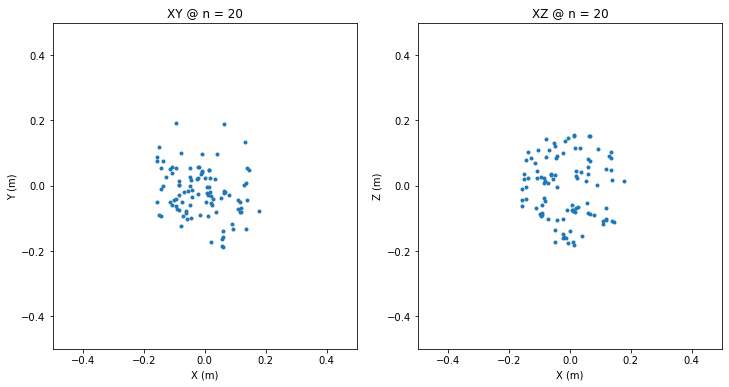

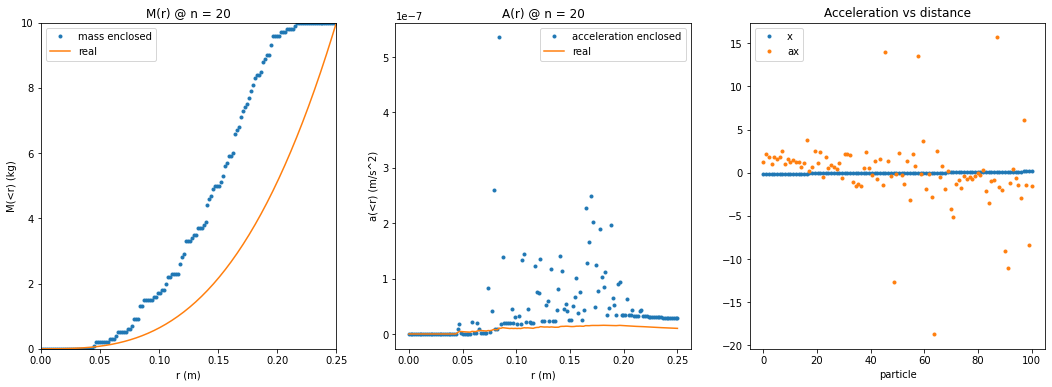

21 95.83 96.0 196.0
22 99.54 100.0 174.0
23 92.12 92.0 214.0
24 85.81 86.0 205.0
25 79.74 80.0 164.0
 ------------------------------------------------ n = 25 ------------------------------------------------ 


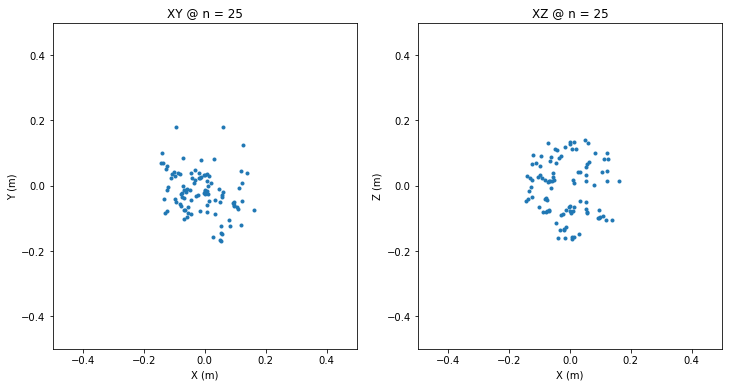

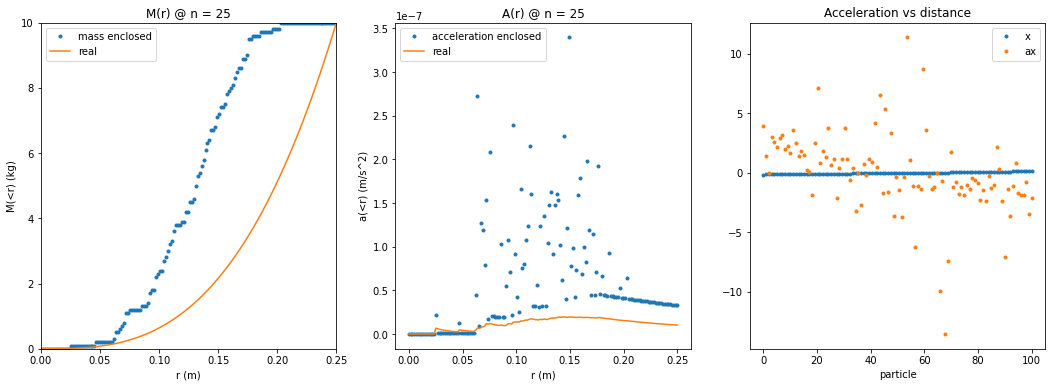

26 74.16 74.0 210.0
27 74.69 75.0 210.0
28 76.61 77.0 185.0
29 76.91 77.0 182.0
30 73.69 74.0 211.0
 ------------------------------------------------ n = 30 ------------------------------------------------ 


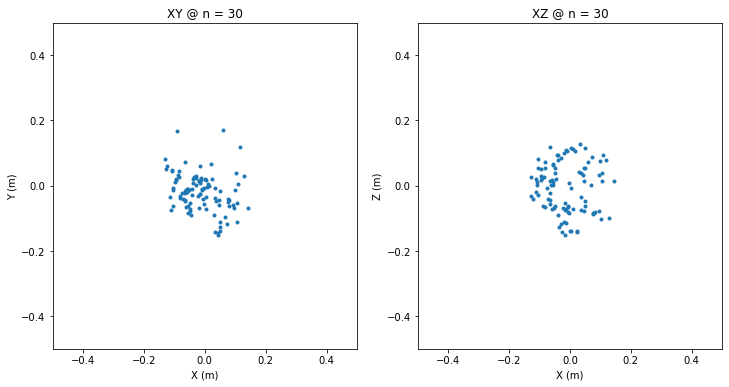

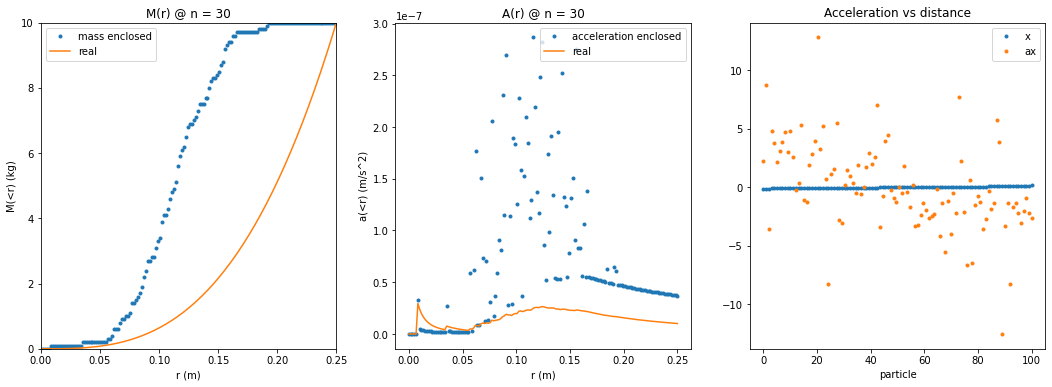

31 69.9 70.0 212.0
32 69.11 69.0 194.0
33 65.25 65.0 162.0
34 61.7 62.0 166.0
35 58.69 59.0 181.0
 ------------------------------------------------ n = 35 ------------------------------------------------ 


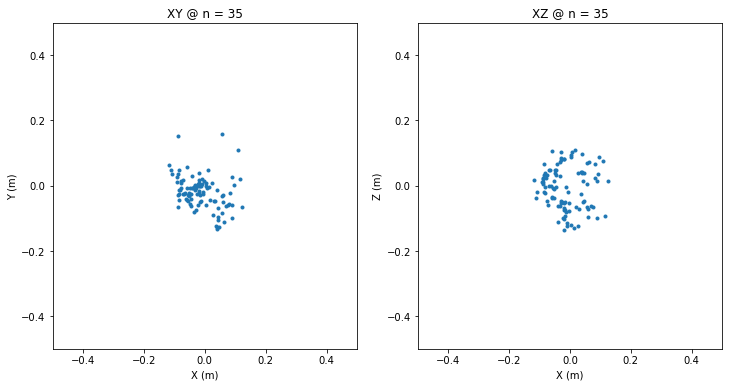

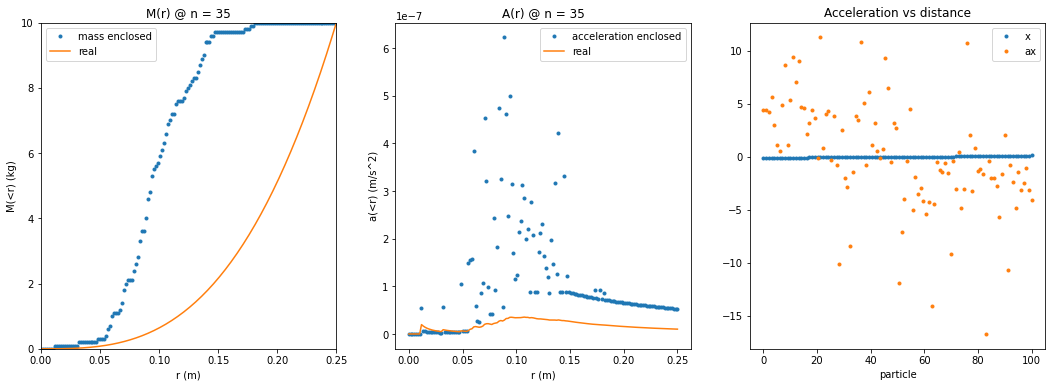

36 57.83 58.0 173.0
37 57.25 57.0 177.0
38 51.83 52.0 146.0
39 48.51 49.0 152.0
40 47.83 48.0 153.0
 ------------------------------------------------ n = 40 ------------------------------------------------ 


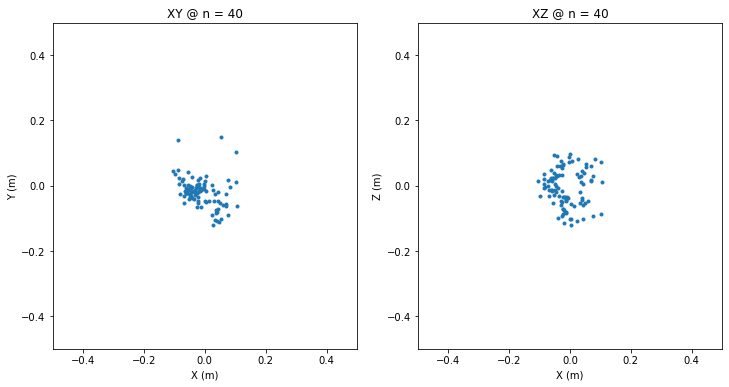

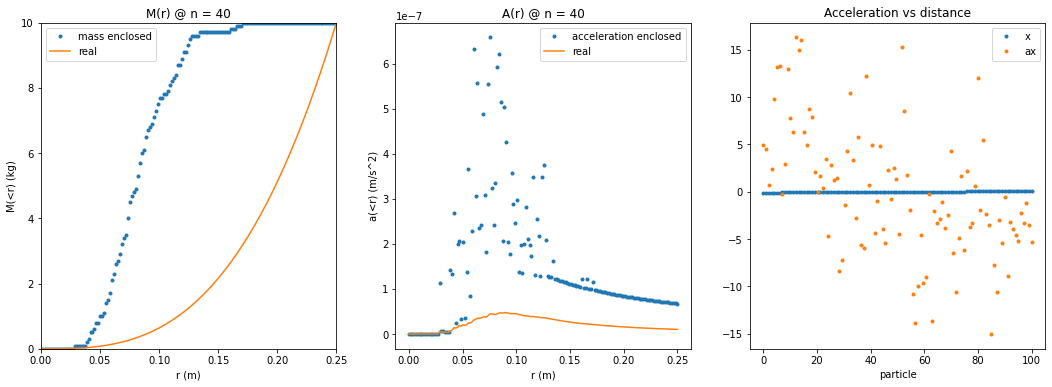

41 48.13 48.0 147.0
42 48.0 48.0 160.0
43 44.78 45.0 153.0
44 42.4 42.0 118.0
45 40.59 41.0 132.0
 ------------------------------------------------ n = 45 ------------------------------------------------ 


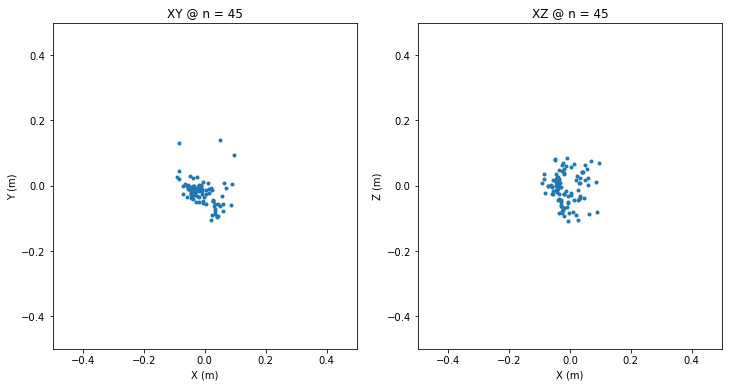

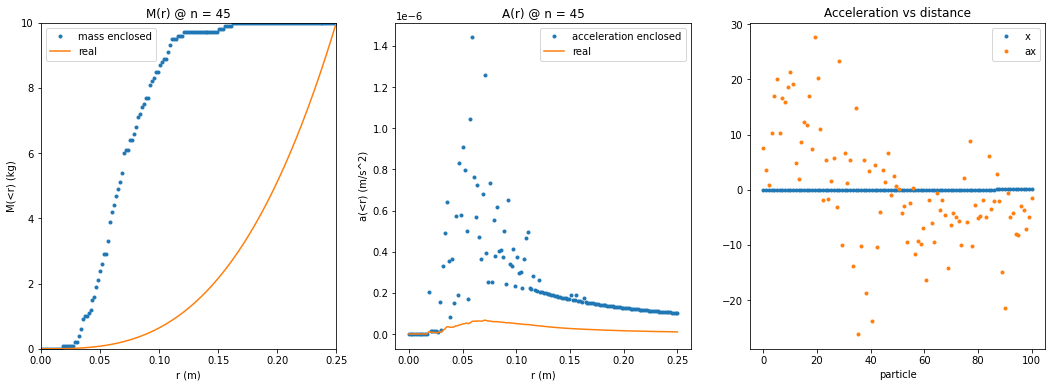

46 39.23 39.0 128.0
47 38.47 38.0 116.0
48 37.4 37.0 113.0
49 34.43 34.0 108.0
50 32.93 33.0 102.0
 ------------------------------------------------ n = 50 ------------------------------------------------ 


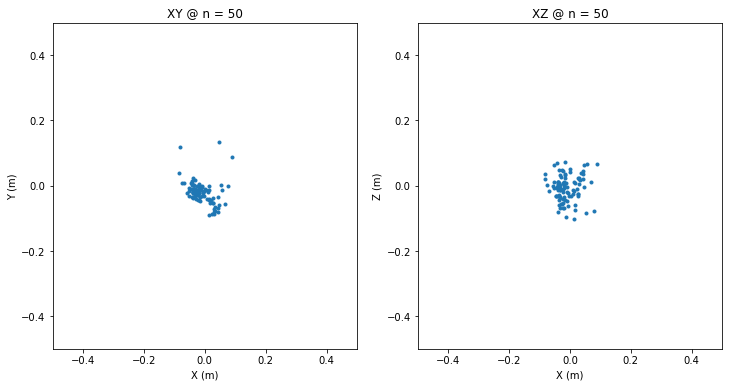

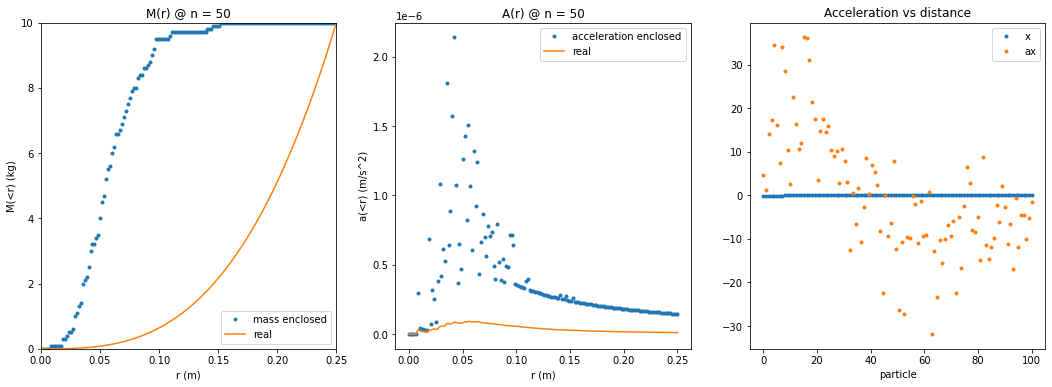

51 32.88 33.0 118.0
52 33.45 33.0 108.0
53 34.67 35.0 117.0
54 34.41 34.0 113.0
55 34.14 34.0 103.0
 ------------------------------------------------ n = 55 ------------------------------------------------ 


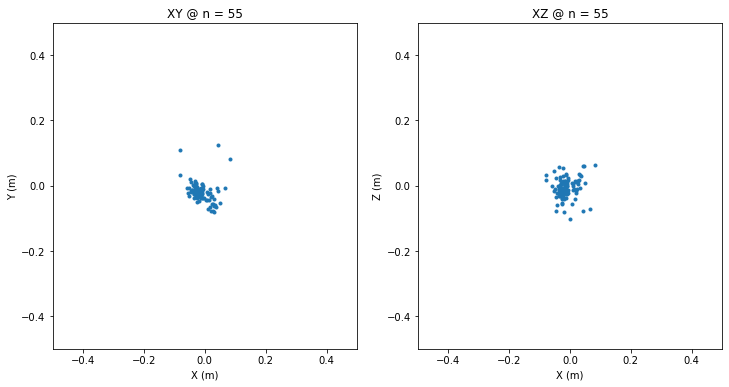

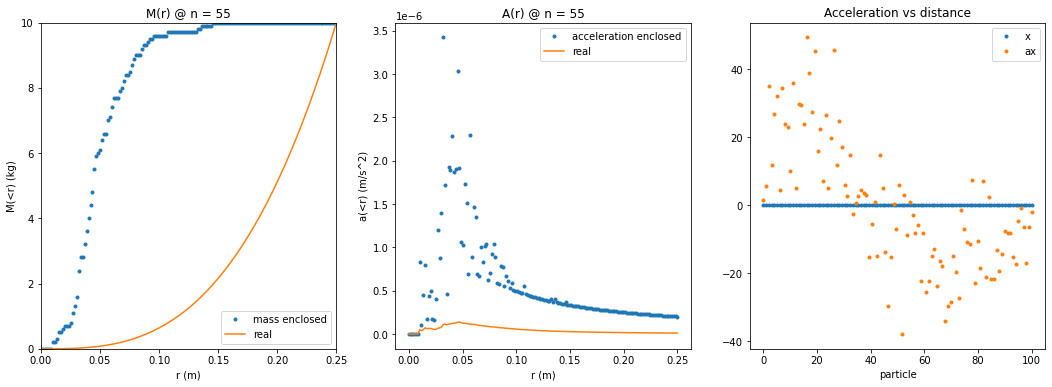

56 33.4 33.0 103.0
57 30.73 31.0 101.0
58 29.45 29.0 97.0
59 29.46 29.0 97.0
60 28.45 28.0 101.0
 ------------------------------------------------ n = 60 ------------------------------------------------ 


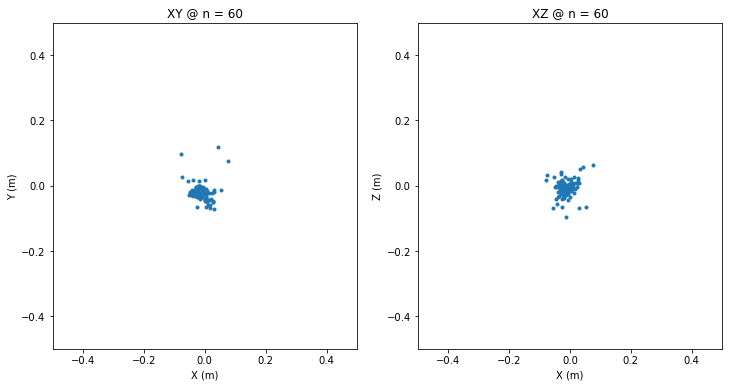

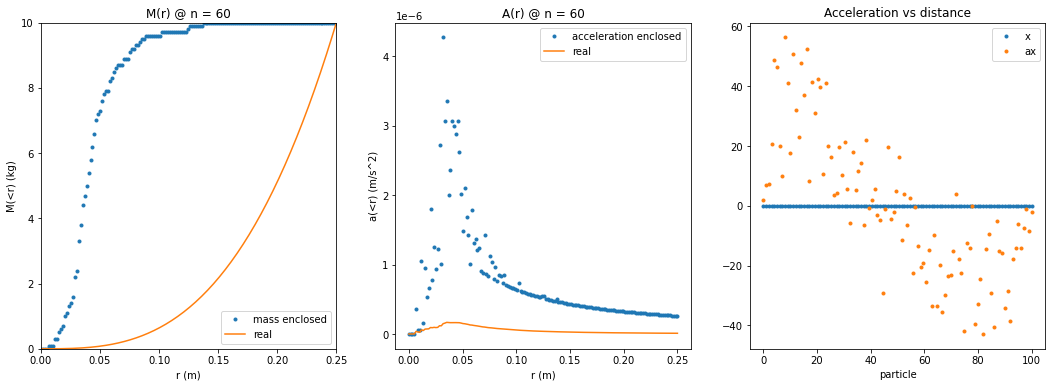

61 27.73 28.0 88.0
62 27.72 28.0 83.0
63 28.11 28.0 97.0
64 29.07 29.0 95.0
65 27.94 28.0 90.0
 ------------------------------------------------ n = 65 ------------------------------------------------ 


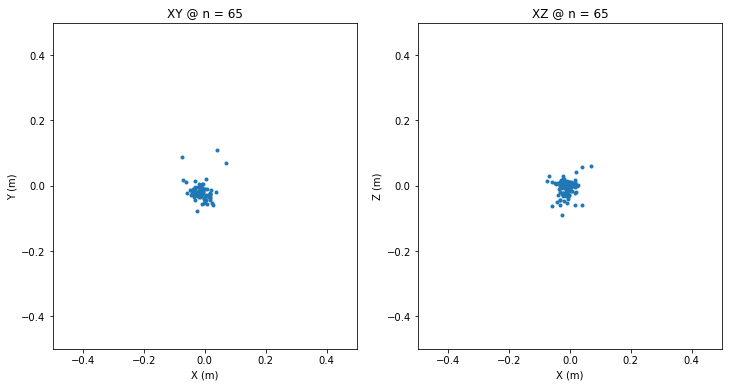

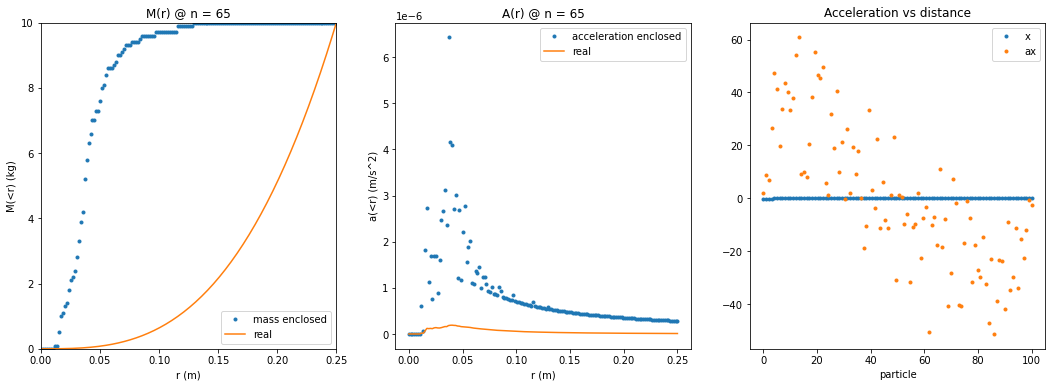

66 26.9 27.0 92.0
67 26.33 26.0 94.0
68 26.72 27.0 96.0
69 27.37 27.0 93.0
70 28.03 28.0 97.0
 ------------------------------------------------ n = 70 ------------------------------------------------ 


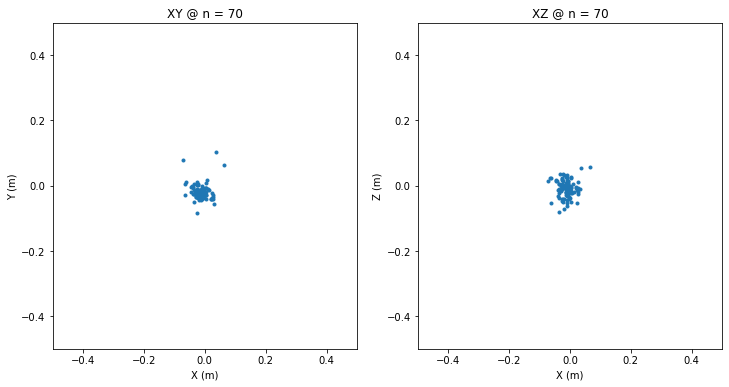

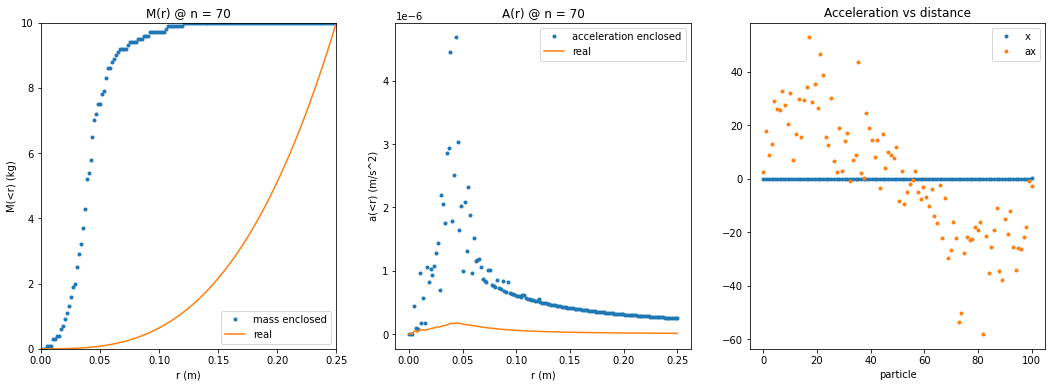

71 29.16 29.0 102.0
72 30.06 30.0 107.0
73 29.86 30.0 113.0
74 29.84 30.0 112.0
75 30.37 30.0 120.0
 ------------------------------------------------ n = 75 ------------------------------------------------ 


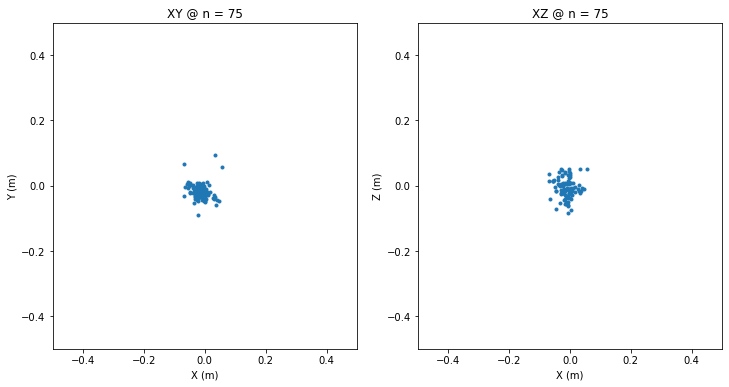

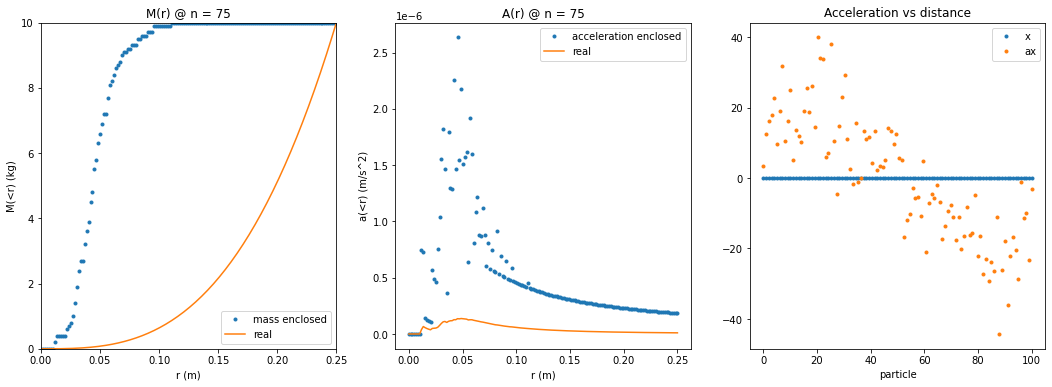

76 31.36 31.0 112.0
77 31.13 31.0 114.0
78 31.64 32.0 128.0
79 32.44 32.0 127.0
80 32.39 32.0 125.0
 ------------------------------------------------ n = 80 ------------------------------------------------ 


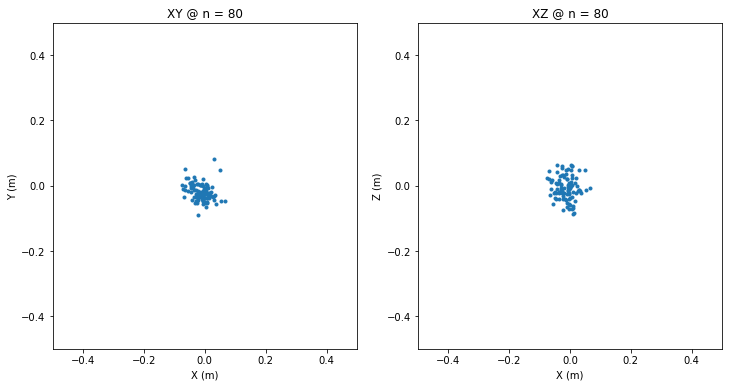

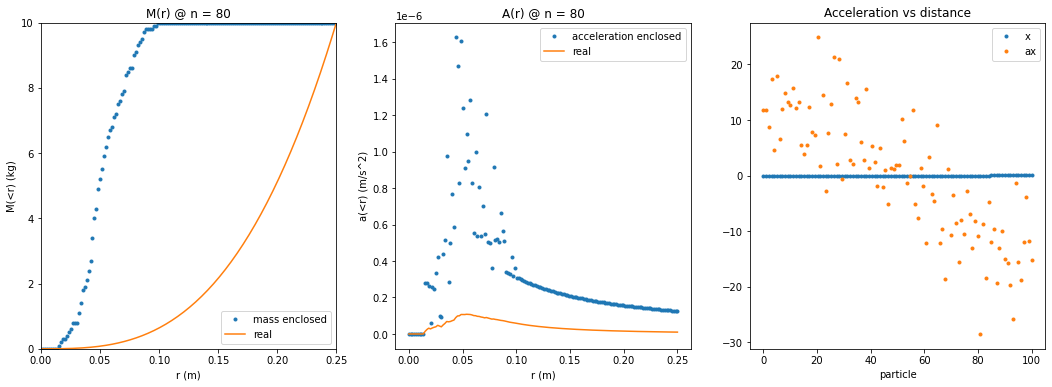

81 32.52 33.0 134.0
82 32.84 33.0 125.0
83 33.47 33.0 130.0
84 33.96 34.0 141.0
85 34.55 35.0 152.0
 ------------------------------------------------ n = 85 ------------------------------------------------ 


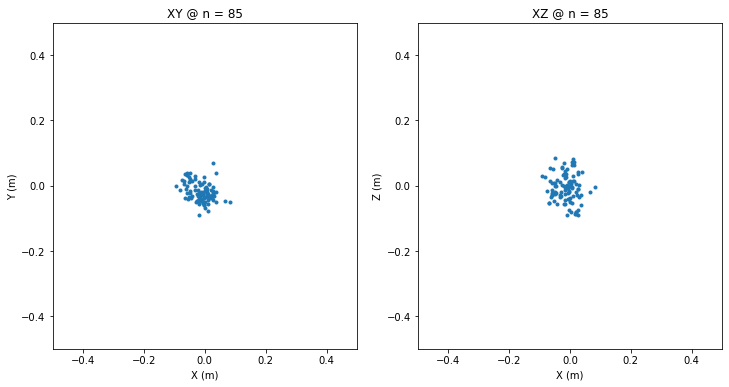

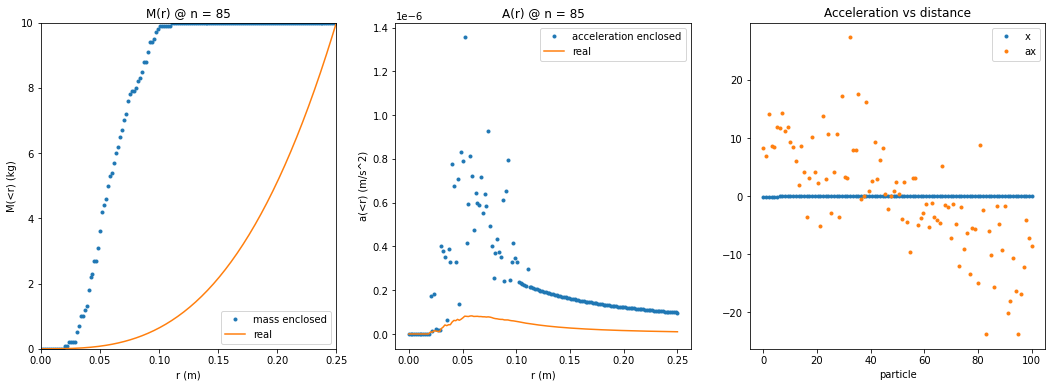

86 35.27 35.0 137.0
87 35.92 36.0 146.0
88 36.32 36.0 133.0
89 37.07 37.0 138.0
90 37.72 38.0 139.0
 ------------------------------------------------ n = 90 ------------------------------------------------ 


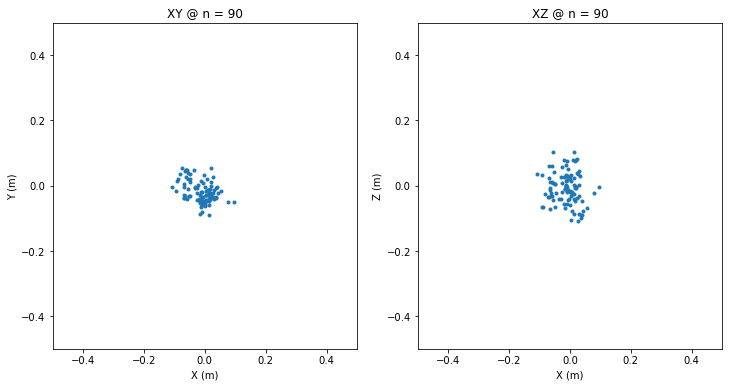

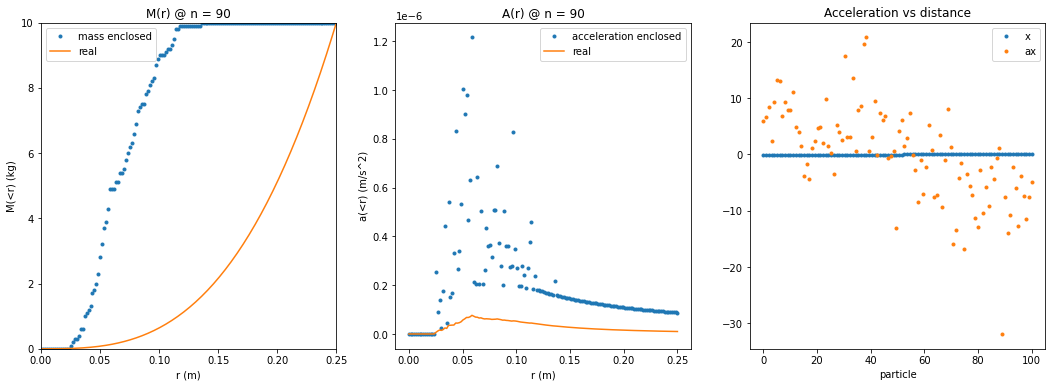

91 38.31 38.0 138.0
92 38.82 39.0 125.0
93 39.22 39.0 147.0
94 39.63 40.0 149.0
95 40.01 40.0 149.0
 ------------------------------------------------ n = 95 ------------------------------------------------ 


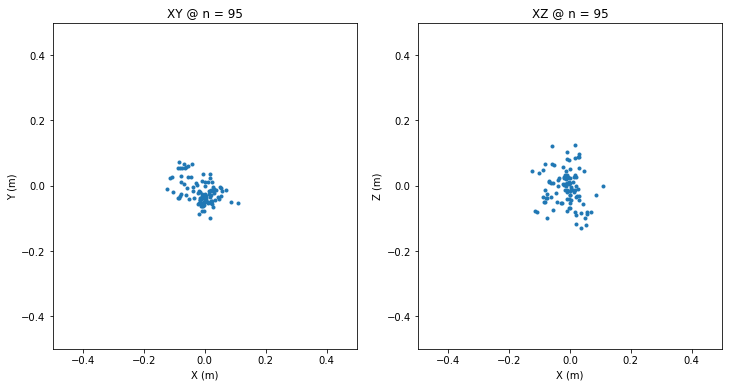

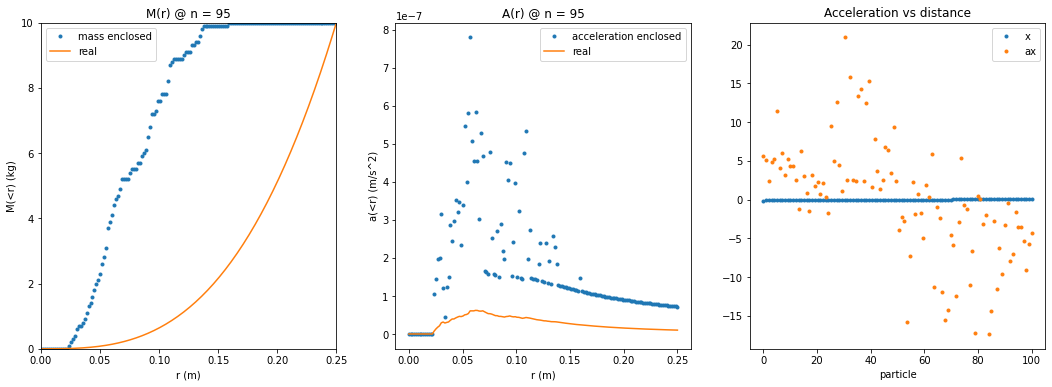

96 40.45 40.0 152.0
97 40.89 41.0 161.0
98 41.02 41.0 160.0
99 40.23 40.0 137.0
100 39.97 40.0 141.0
 ------------------------------------------------ n = 100 ------------------------------------------------ 


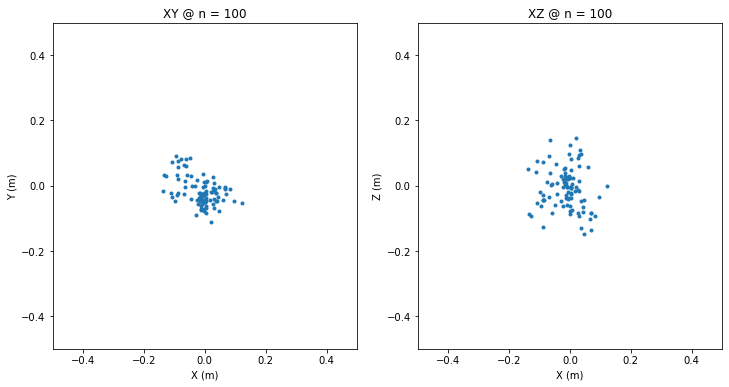

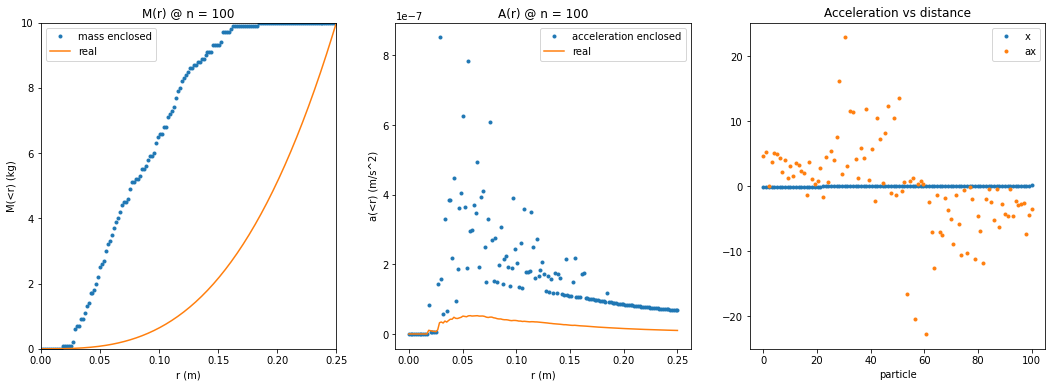

101 39.84 40.0 156.0
102 39.71 40.0 165.0
103 39.89 40.0 167.0
104 40.34 40.0 158.0
105 40.8 41.0 168.0
 ------------------------------------------------ n = 105 ------------------------------------------------ 


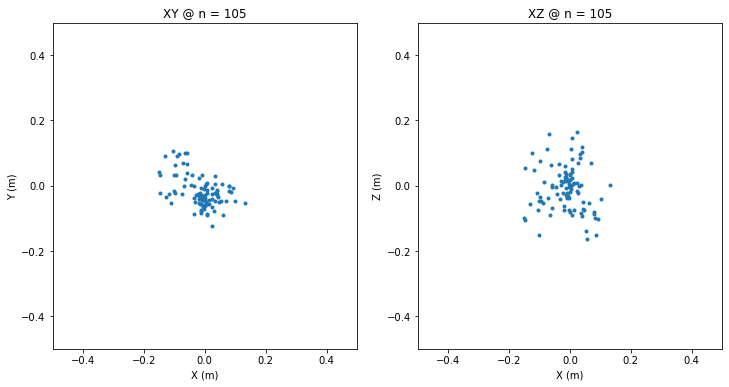

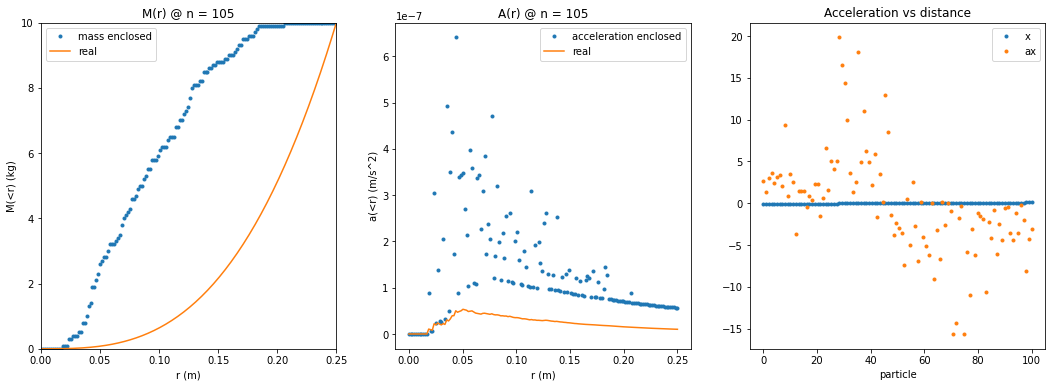

106 41.42 41.0 166.0
107 42.37 42.0 164.0
108 40.27 40.0 158.0
109 39.27 39.0 151.0
110 40.29 40.0 154.0
 ------------------------------------------------ n = 110 ------------------------------------------------ 


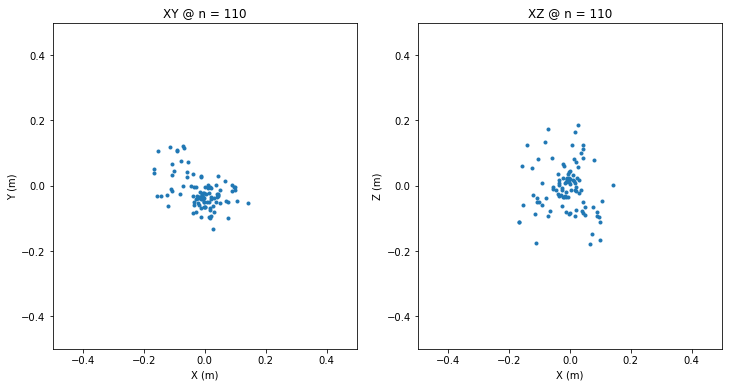

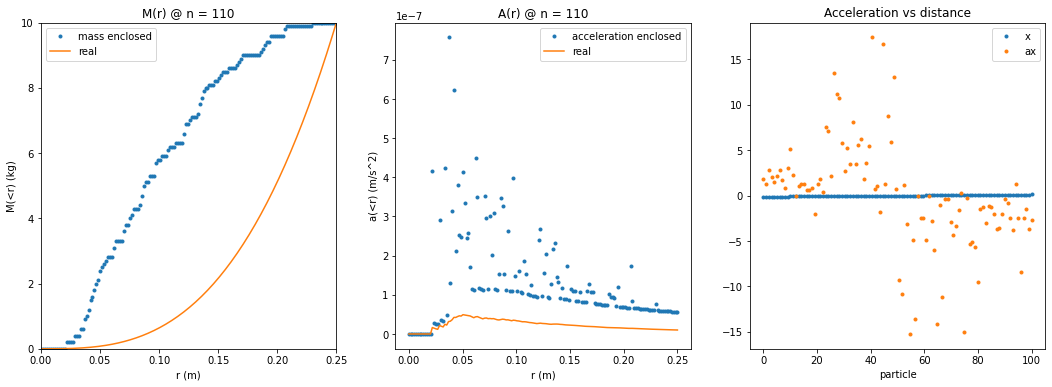

111 42.02 42.0 168.0
112 43.48 43.0 158.0
113 45.08 45.0 149.0
114 46.61 47.0 173.0
115 47.59 48.0 157.0
 ------------------------------------------------ n = 115 ------------------------------------------------ 


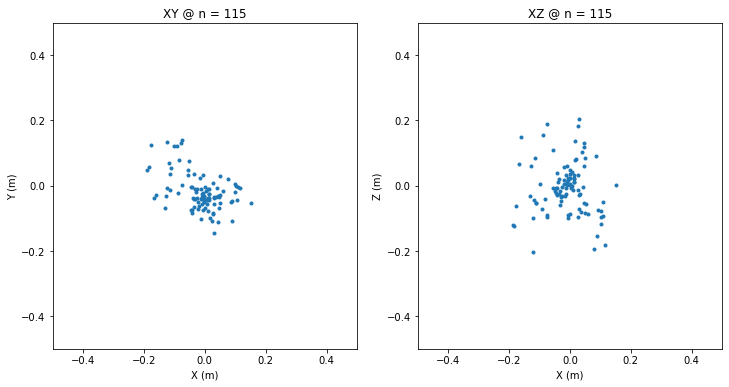

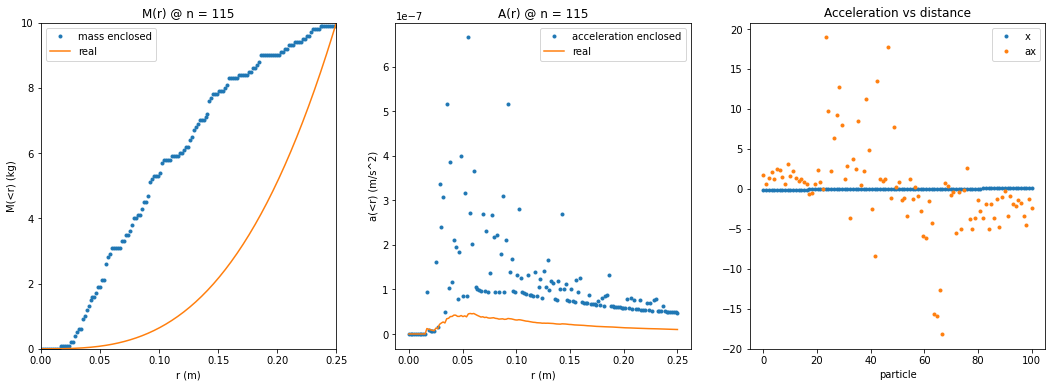

116 47.84 48.0 160.0
117 48.09 48.0 157.0
118 48.32 48.0 162.0
119 48.54 49.0 158.0
120 48.75 49.0 163.0
 ------------------------------------------------ n = 120 ------------------------------------------------ 


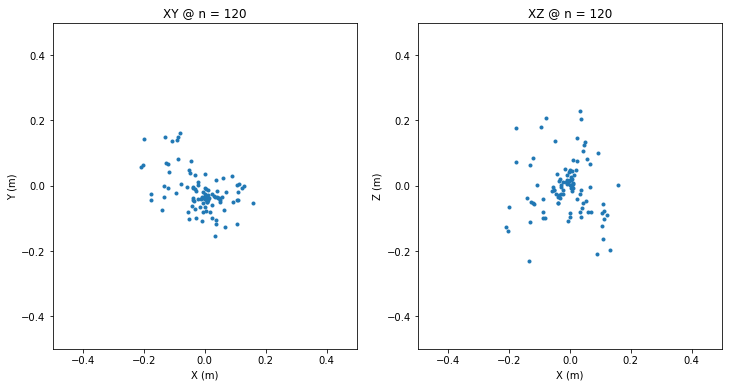

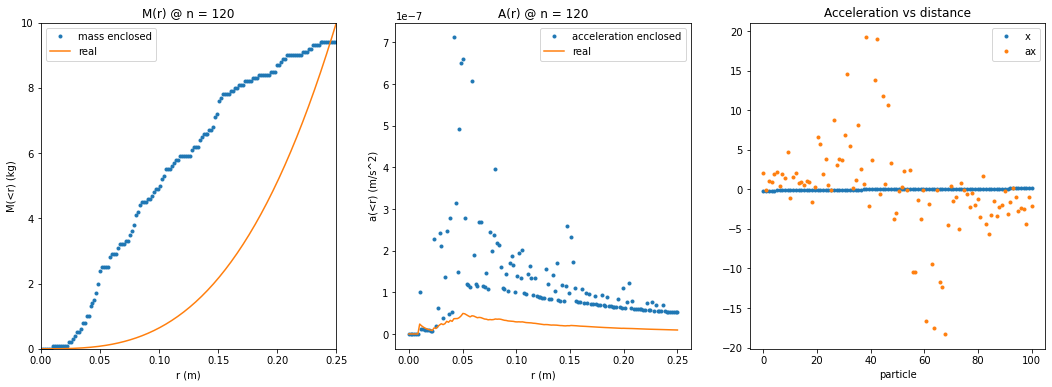

121 48.94 49.0 138.0
122 49.13 49.0 137.0
123 49.31 49.0 145.0
124 49.49 49.0 136.0
125 49.66 50.0 142.0
 ------------------------------------------------ n = 125 ------------------------------------------------ 


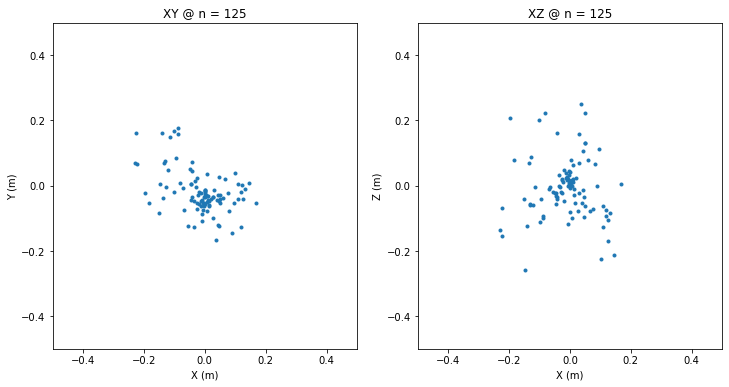

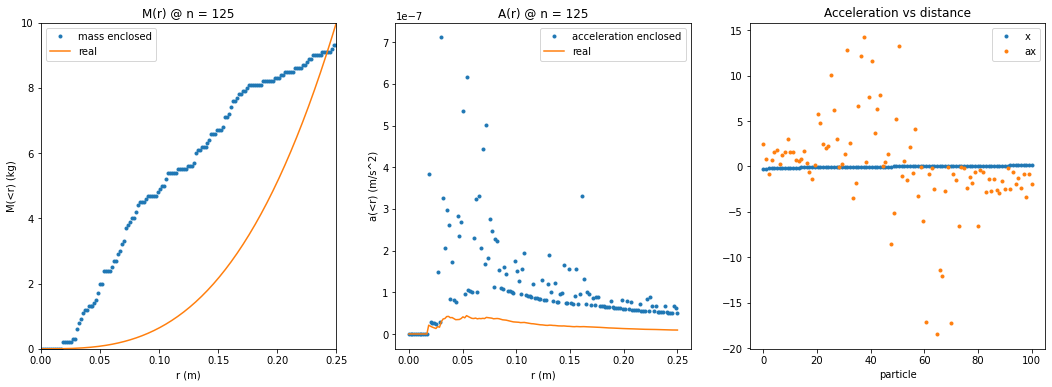

126 49.82 50.0 130.0
127 49.97 50.0 147.0
128 50.12 50.0 131.0
129 50.26 50.0 140.0
130 50.4 50.0 153.0
 ------------------------------------------------ n = 130 ------------------------------------------------ 


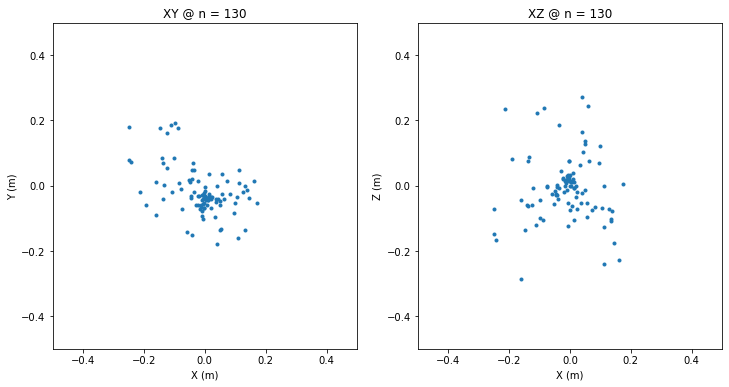

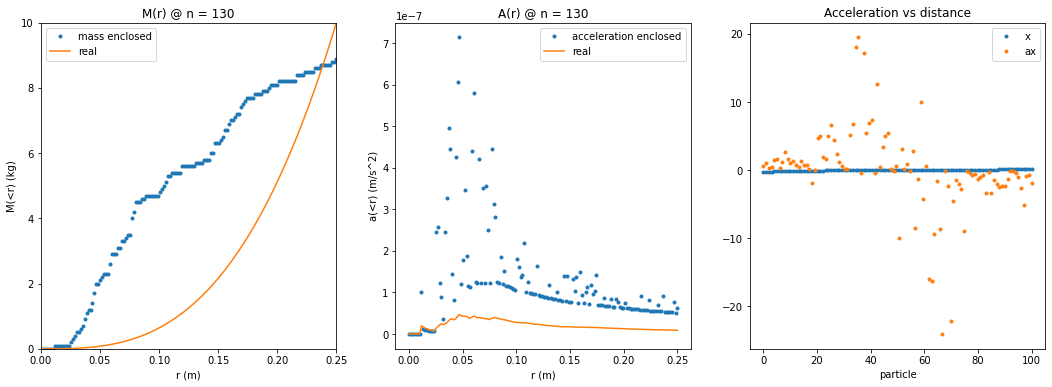

131 50.53 51.0 149.0
132 50.65 51.0 146.0
133 50.77 51.0 136.0
134 50.88 51.0 145.0
135 50.99 51.0 136.0
 ------------------------------------------------ n = 135 ------------------------------------------------ 


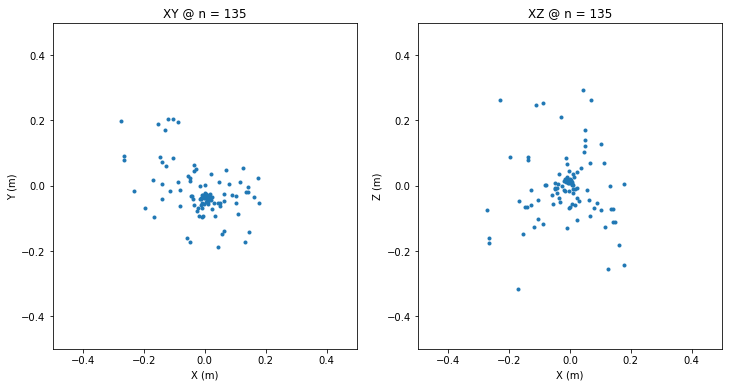

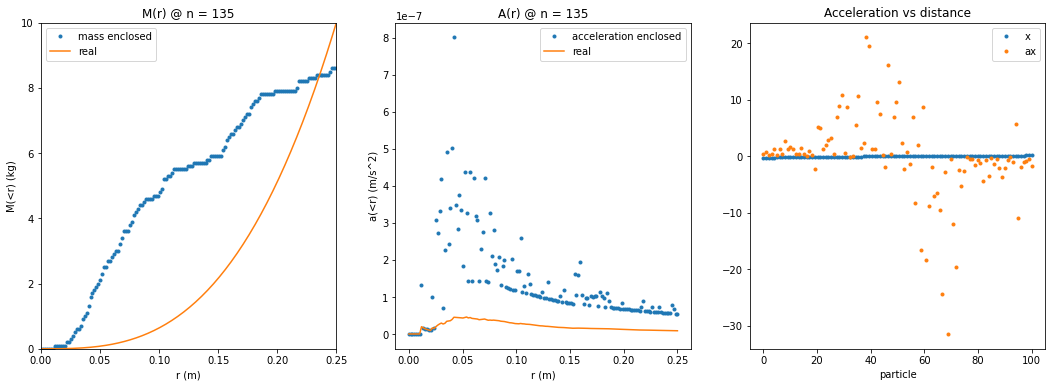

136 51.1 51.0 135.0
137 47.82 48.0 140.0
138 45.82 46.0 141.0
139 45.33 45.0 143.0
140 45.77 46.0 139.0
 ------------------------------------------------ n = 140 ------------------------------------------------ 


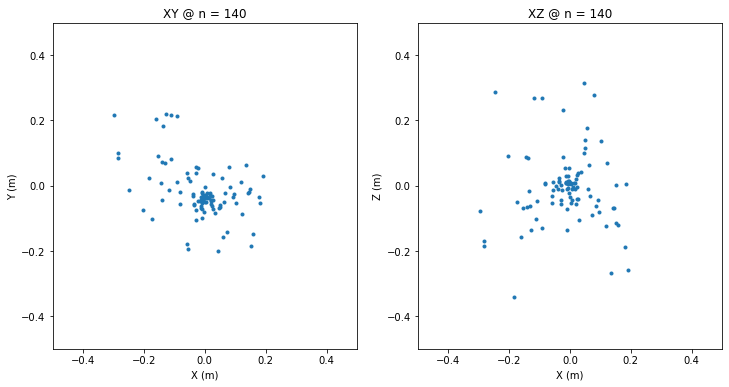

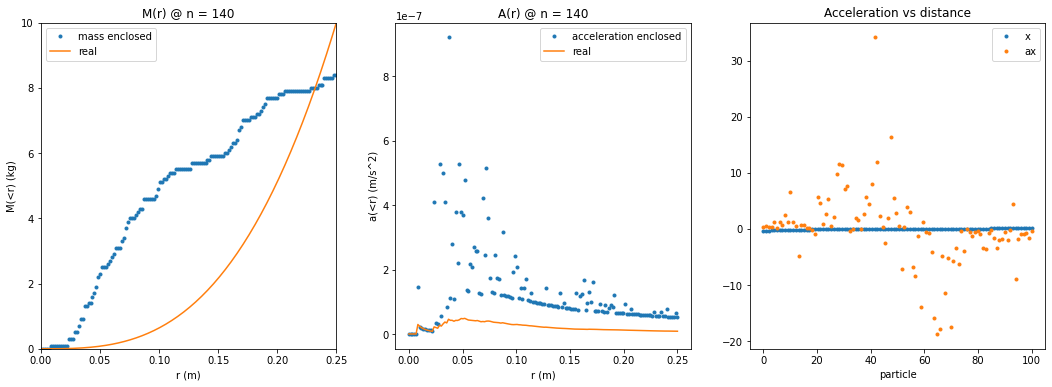

141 47.48 47.0 144.0
142 50.77 51.0 152.0
143 51.68 52.0 166.0
144 50.86 51.0 155.0
145 51.59 52.0 153.0
 ------------------------------------------------ n = 145 ------------------------------------------------ 


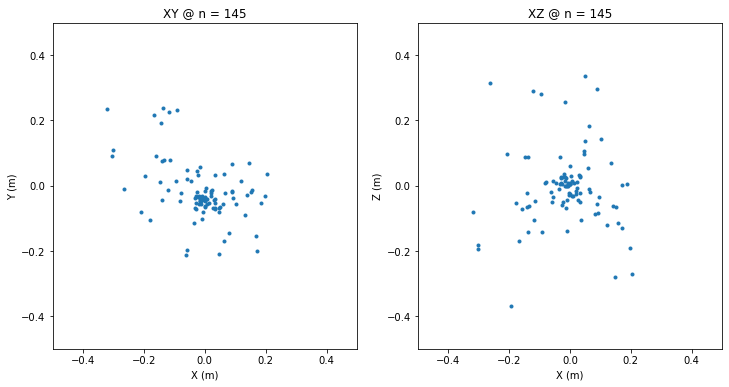

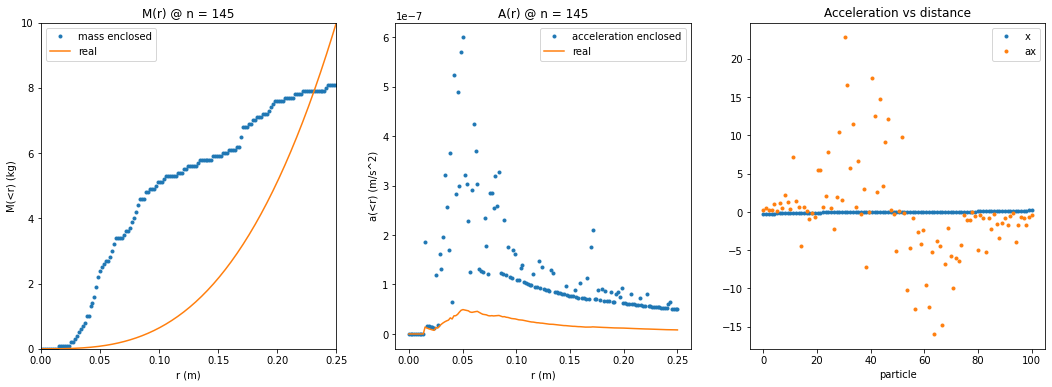

146 51.46 51.0 139.0
147 51.79 52.0 141.0
148 52.03 52.0 147.0
149 51.89 52.0 155.0
150 51.17 51.0 143.0
 ------------------------------------------------ n = 150 ------------------------------------------------ 


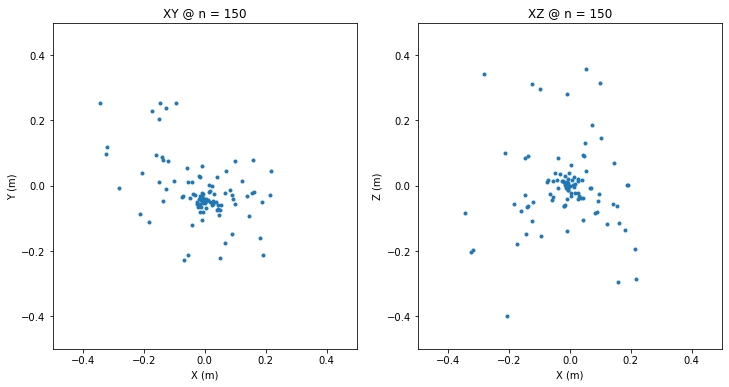

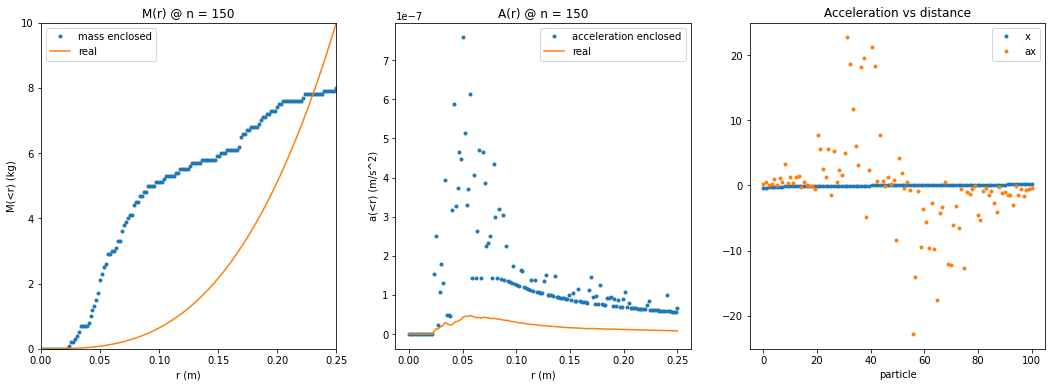

151 49.86 50.0 121.0
152 46.69 47.0 141.0
153 46.96 47.0 136.0
154 49.29 49.0 145.0
155 51.95 52.0 142.0
 ------------------------------------------------ n = 155 ------------------------------------------------ 


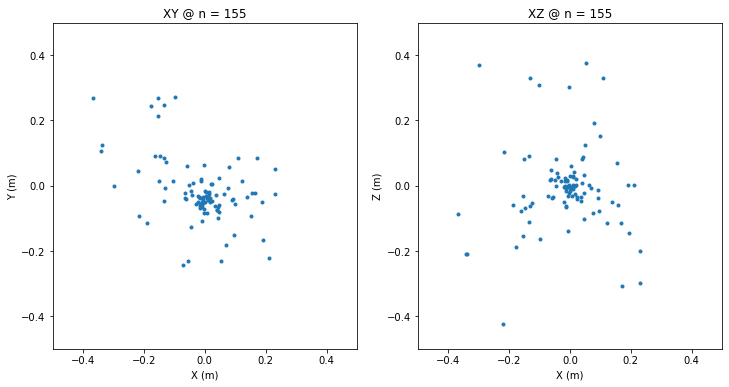

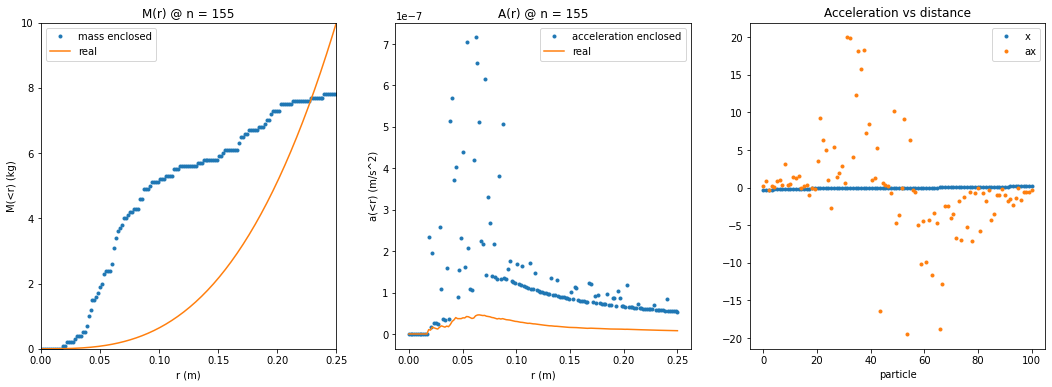

156 52.43 52.0 139.0
157 52.47 52.0 148.0
158 52.5 53.0 155.0
159 52.54 53.0 147.0
160 52.57 53.0 149.0
 ------------------------------------------------ n = 160 ------------------------------------------------ 


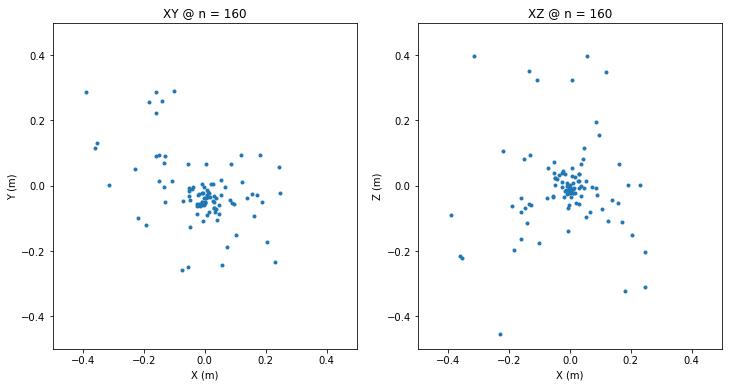

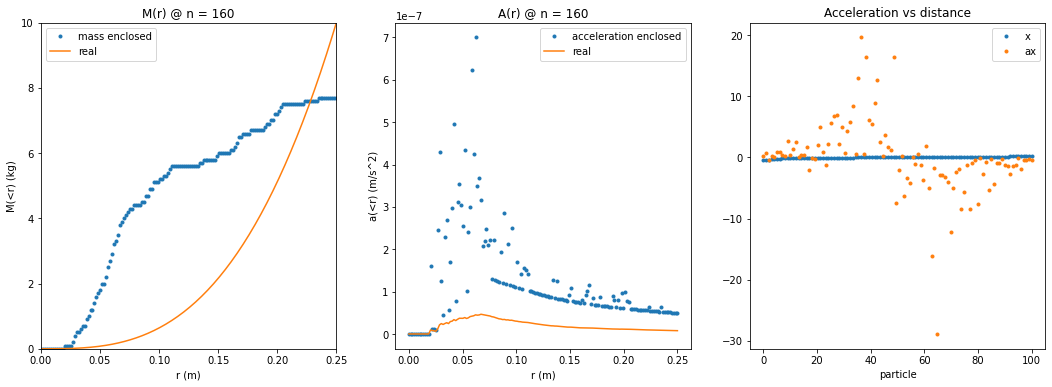

161 52.6 53.0 150.0
162 52.63 53.0 150.0
163 52.65 53.0 158.0
164 52.68 53.0 157.0
165 52.7 53.0 158.0
 ------------------------------------------------ n = 165 ------------------------------------------------ 


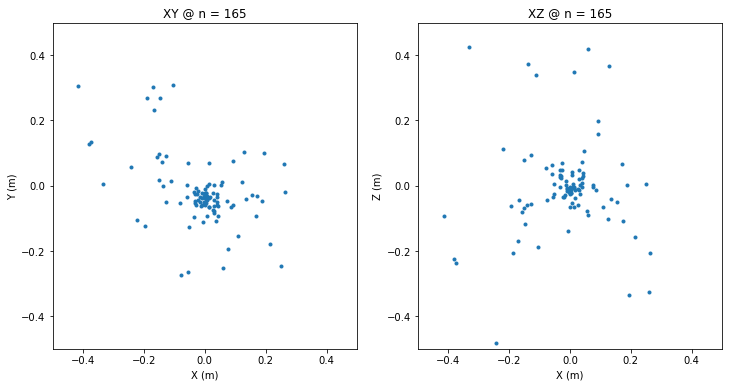

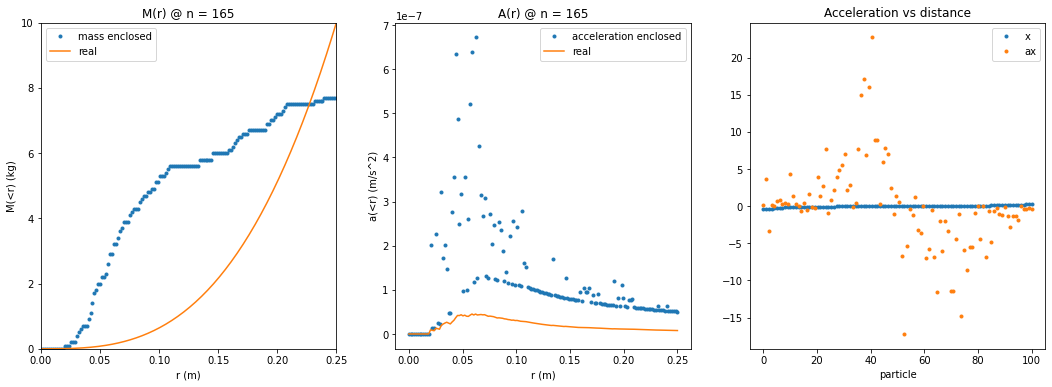

166 52.73 53.0 144.0
167 52.75 53.0 156.0
168 52.42 52.0 135.0
169 52.78 53.0 155.0
170 52.8 53.0 153.0
 ------------------------------------------------ n = 170 ------------------------------------------------ 


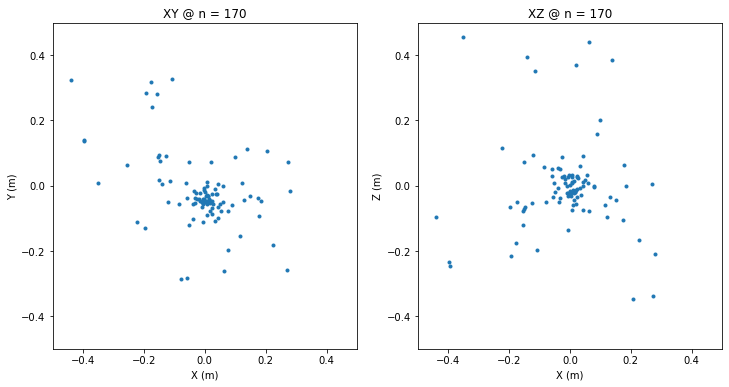

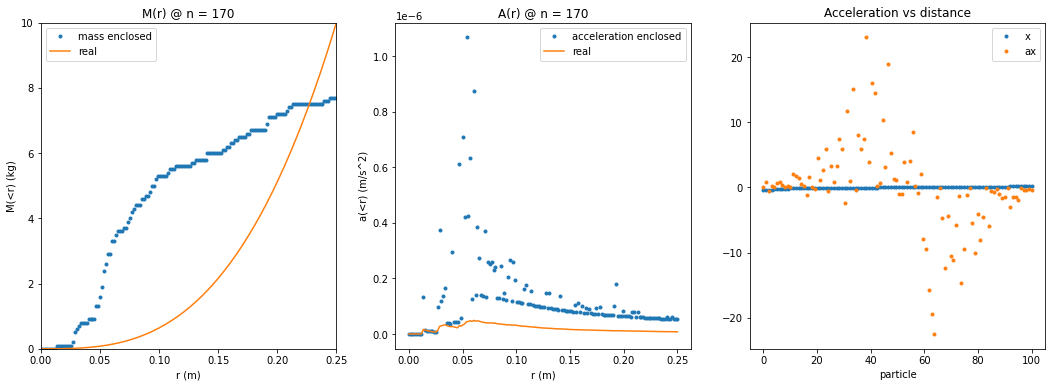

171 52.82 53.0 144.0
172 52.84 53.0 126.0
173 52.86 53.0 155.0
174 52.87 53.0 161.0
175 52.89 53.0 177.0
 ------------------------------------------------ n = 175 ------------------------------------------------ 


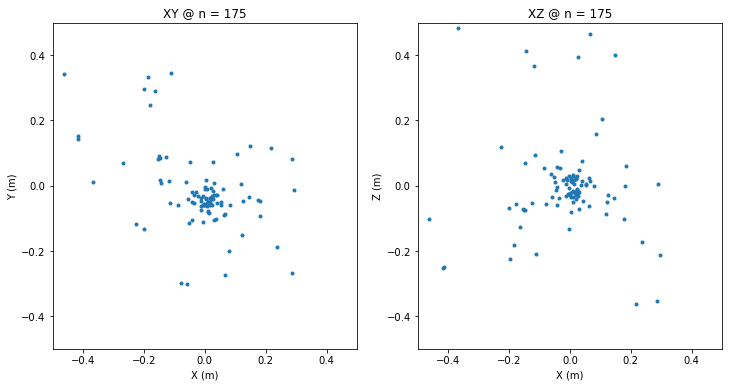

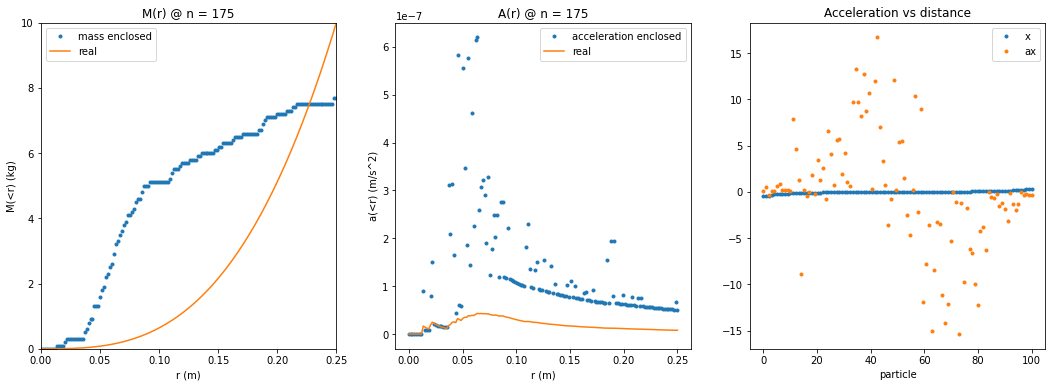

176 52.9 53.0 161.0
177 52.9 53.0 158.0
178 52.28 52.0 174.0
179 52.16 52.0 154.0
180 52.5 52.0 162.0
 ------------------------------------------------ n = 180 ------------------------------------------------ 


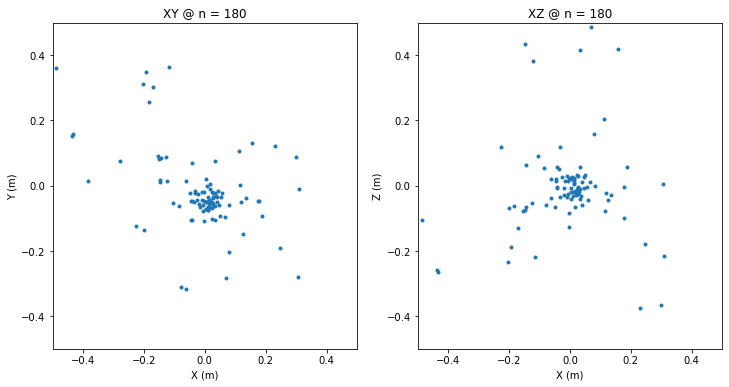

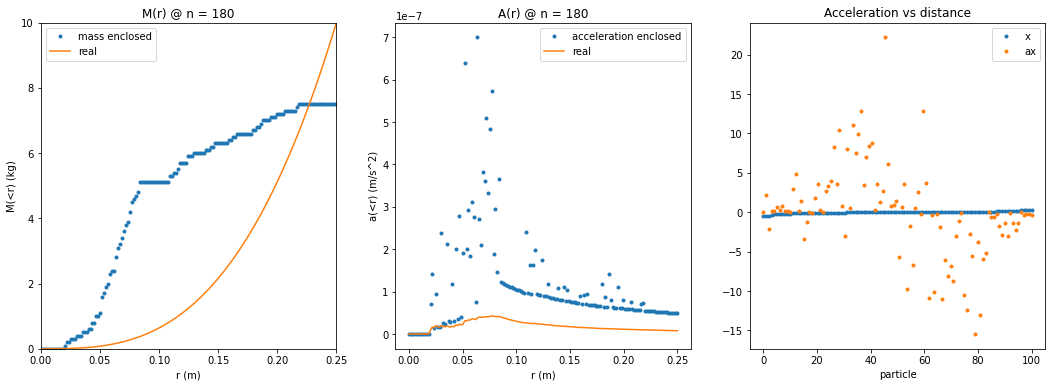

181 52.89 53.0 148.0
182 52.71 53.0 148.0
183 51.89 52.0 127.0
184 52.56 53.0 158.0
185 52.99 53.0 155.0
 ------------------------------------------------ n = 185 ------------------------------------------------ 


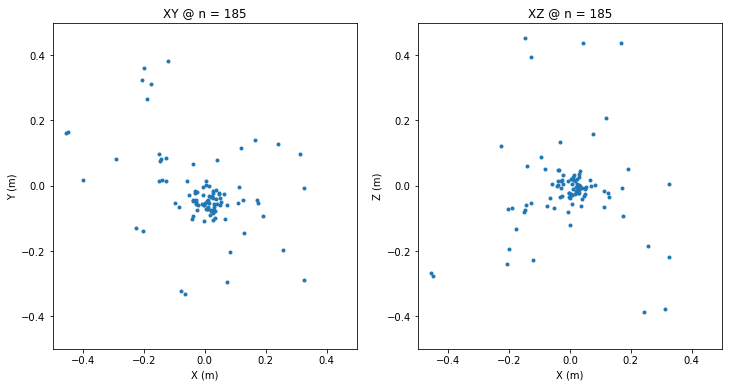

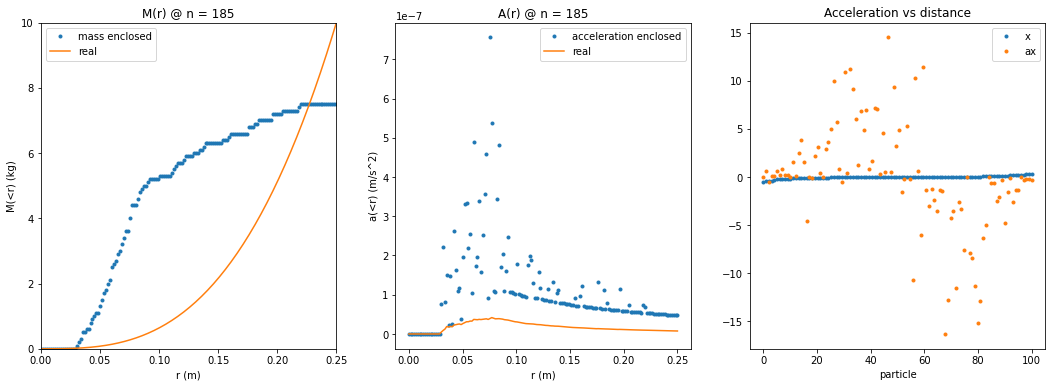

186 52.99 53.0 137.0
187 52.97 53.0 173.0
188 51.06 51.0 168.0
189 49.75 50.0 174.0
190 48.61 49.0 180.0
 ------------------------------------------------ n = 190 ------------------------------------------------ 


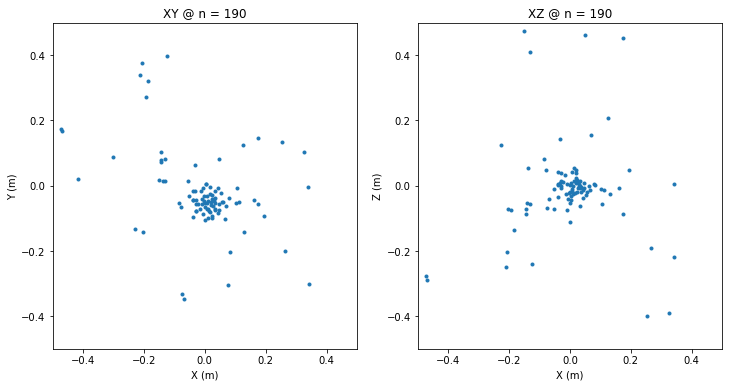

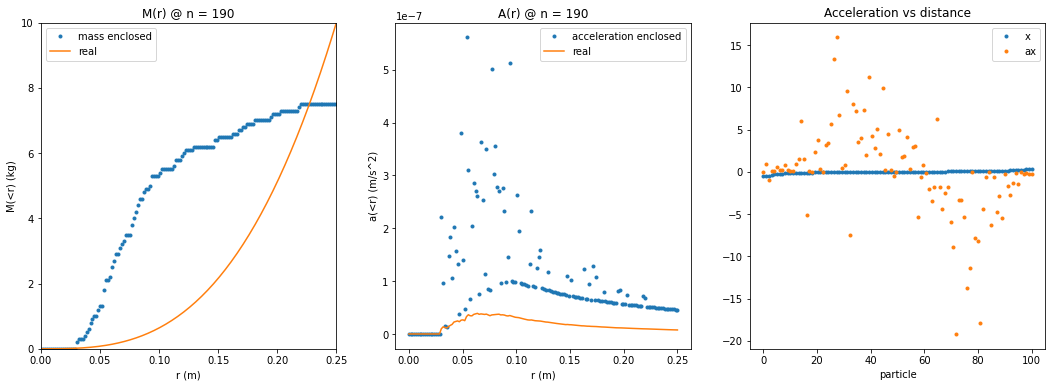

191 47.43 47.0 182.0
192 46.93 47.0 170.0
193 48.5 48.0 166.0
194 51.22 51.0 188.0
195 52.6 53.0 192.0
 ------------------------------------------------ n = 195 ------------------------------------------------ 


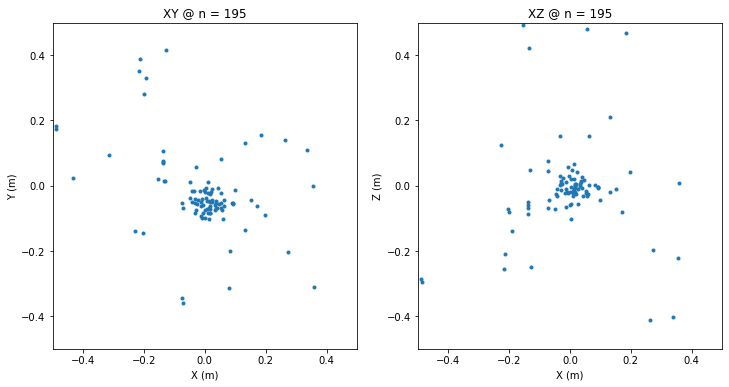

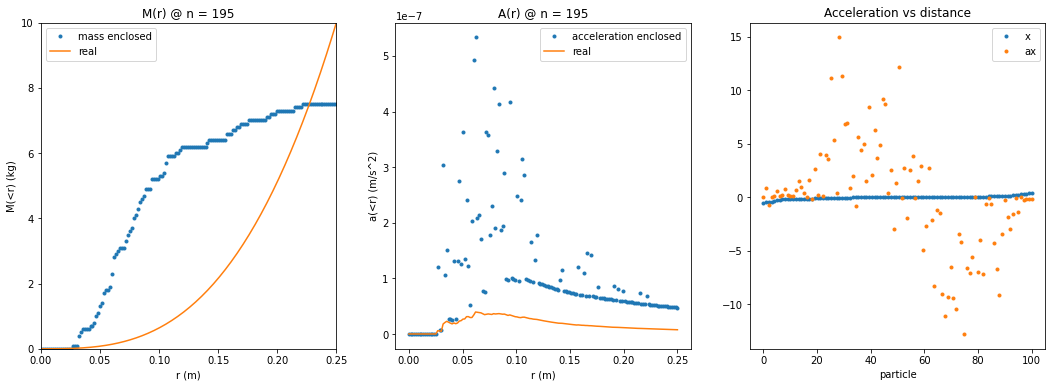

196 52.91 53.0 149.0
197 52.61 53.0 141.0
198 51.16 51.0 181.0
199 50.98 51.0 121.0
200 52.76 53.0 157.0
 ------------------------------------------------ n = 200 ------------------------------------------------ 


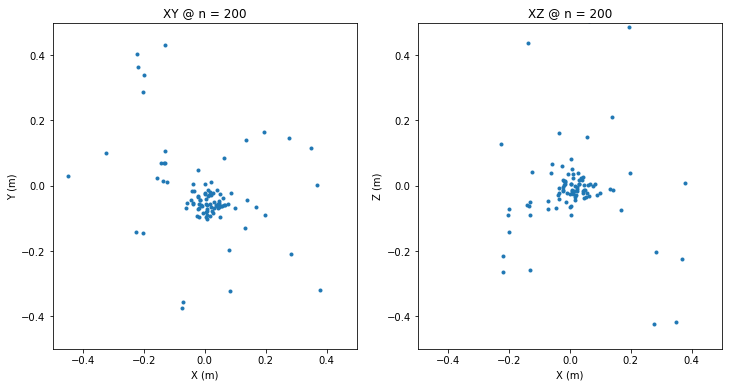

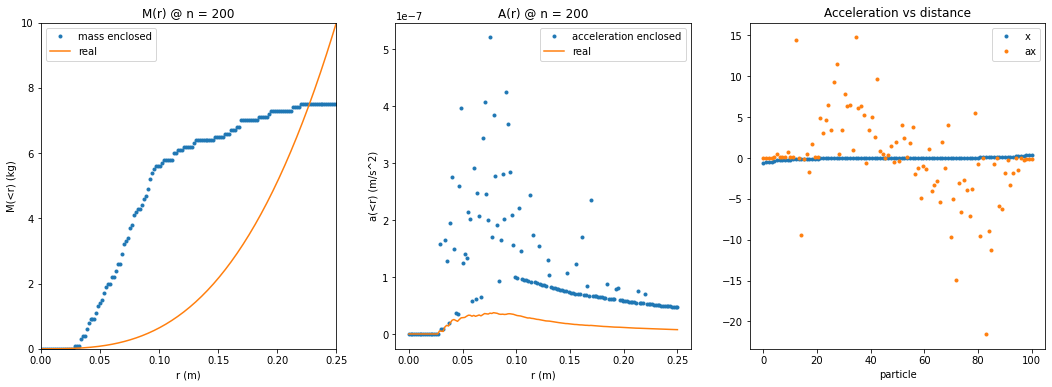

In [41]:
verlet(part, wk, f0, dt0, N_step = 200, mult = 5, lam = 1)
plt.show()